In [3]:
import os
import re
import ast
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from nltk.tokenize import RegexpTokenizer
from preprocess import preprocess
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load training and test data from CSV files in the 'data' directory.
train_data = pd.read_csv(os.path.join("data", "train.csv"))
test_data = pd.read_csv(os.path.join("data", "test.csv"))

# Fill missing values in specific columns with default values.
train_data["description"].fillna("", inplace=True)  # Replace missing descriptions with empty strings.
train_data["host_is_superhost"].fillna("f", inplace=True)  # Replace missing superhost info with 'f' (false).
train_data["beds"].fillna("1", inplace=True)  # Replace missing bed counts with 1.

# Drop any remaining rows with missing values in the training data.
train_data.dropna(inplace=True)

# Separate features (X) and target variable (y) for the training data.
X, y = train_data.drop(["price"], axis=1), train_data["price"]
y = y.to_numpy().astype(int)  # Convert the target variable to integer format.

# Split the training data into training and validation sets.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
X_test = test_data  # Assign the test data to X_test.

# Preprocess the training, validation, and test data.
X_train = preprocess(X_train).to_numpy().astype(float)
X_val = preprocess(X_val).to_numpy().astype(float)
X_test = preprocess(X_test)

# Initialize and fit a RobustScaler for feature scaling.
scaler = RobustScaler()
scaler.fit(X_train)  # Fit the scaler on the training data only to avoid data leakage.

# Transform the training and validation data using the fitted scaler.
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

# Print the shape of the transformed training data.
X_train.shape


(12346, 351)

Results may deviate from what I reported since I did a final cross validation run over some additional variables. 

In [4]:
import xgboost as xgb

# Define a dictionary of hyperparameters to search over
param_grid = {
    'n_estimators': [10, 30, 50, 70],  # Number of trees in the XGBoost model
    'learning_rate': [0.1, 0.3, 1.0],  # Learning rate for the boosting process
    'eval_metric': ["mlogloss", "merror"],  # Evaluation metric for the model
    'max_depth': [3, 4, 5, 6, 7, 8],  # Maximum depth of each tree in the ensemble
    'subsample': [0.7, 0.8, 0.9, 1.0],  # Fraction of training data used for each tree
}

# Create an XGBoost Classifier with a specified objective
xgb_clf = xgb.XGBClassifier(
    objective="multi:softmax"
)

# Create a GridSearchCV object to perform hyperparameter tuning
# - xgb_clf: the classifier to optimize
# - param_grid: the dictionary of hyperparameters to search over
# - cv=5: perform 5-fold cross-validation during the search
# - verbose=3: display detailed progress messages
# - n_jobs=20: use 20 CPU cores for parallel processing (adjust as needed)
# - scoring="accuracy": use accuracy as the scoring metric
gscv2 = GridSearchCV(xgb_clf, param_grid, cv=5, verbose=3, n_jobs=20, scoring="accuracy")

# Fit the GridSearchCV object to the training data, finding the best hyperparameters
gscv2.fit(X_train, y_train)

# Update the xgb_clf to use the best estimator found during the search
xgb_clf = gscv2.best_estimator_

# Calculate the accuracy of the tuned XGBoost model on the validation data
xgb_test_accuracy = xgb_clf.score(X_val, y_val)

# Print the validation accuracy of the XGBoost model
print("XGBoost Val Accuracy:", xgb_test_accuracy)


Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[CV 2/5] END class_weight=None, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0;, score=0.431 total time=   0.4s
[CV 3/5] END class_weight=None, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.9;, score=0.452 total time=   0.5s
[CV 1/5] END class_weight=None, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0;, score=0.434 total time=   0.5s
[CV 3/5] END class_weight=None, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.8;, score=0.444 total time=   0.5s
[CV 3/5] END class_weight=None, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0;, score=0.446 total time=   0.4s
[CV 1/5] END class_weight=None, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.9;, score=0.431 total time=   0.5s
[CV 5/5] END class_weight=None, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=1

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7;, score=0.434 total time=   0.5s
[CV 4/5] END class_weight=None, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.7;, score=0.509 total time=   5.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=None, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.7;, score=0.511 total time=   5.9s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7;, score=0.437 total time=   0.4s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7;, score=0.457 total time=   0.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7;, score=0.430 total time=   0.4s
[CV 2/5] END class_weight=None, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.8;, score=0.511 total time=   5.9s
[CV 1/5] END class_weight=None, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.8;, score=0.517 total time=   6.1s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.8;, score=0.435 total time=   0.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7;, score=0.441 total time=   0.7s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.8;, score=0.437 total time=   0.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.8;, score=0.444 total time=   0.4s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.8;, score=0.430 total time=   0.4s
[CV 2/5] END class_weight=None, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.9;, score=0.516 total time=   4.9s
[CV 4/5] END class_weight=None, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.8;, score=0.524 total time=   5.7s
[CV 1/5] END class_weight=None, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.9;, score=0.533 total time=   5.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.8;, score=0.442 total time=   0.7s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.9;, score=0.437 total time=   0.4s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.9;, score=0.452 total time=   0.4s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.9;, score=0.431 total time=   0.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.9;, score=0.448 total time=   0.4s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.9;, score=0.426 total time=   0.4s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0;, score=0.431 total time=   0.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0;, score=0.441 total time=   0.4s
[CV 1/5] END class_weight=None, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.7;, score=0.524 total time=   7.8s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0;, score=0.427 total time=   0.4s
[CV 5/5] END class_weight=None, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.8;, score=0.546 total time=   5.8s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0;, score=0.434 total time=   0.7s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0;, score=0.446 total time=   0.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=None, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=1.0;, score=0.538 total time=   5.0s
[CV 3/5] END class_weight=None, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=1.0;, score=0.534 total time=   4.9s
[CV 5/5] END class_weight=None, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.7;, score=0.523 total time=   7.8s
[CV 4/5] END class_weight=None, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=1.0;, score=0.528 total time=   5.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=None, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=1.0;, score=0.520 total time=   5.2s
[CV 3/5] END class_weight=None, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.9;, score=0.521 total time=   6.1s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.7;, score=0.461 total time=   1.0s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.7;, score=0.489 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.7;, score=0.471 total time=   1.2s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.7;, score=0.464 total time=   1.0s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.8;, score=0.457 total time=   1.0s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.8;, score=0.459 total time=   1.0s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.8;, score=0.468 total time=   1.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=None, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.9;, score=0.532 total time=   6.0s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.7;, score=0.464 total time=   1.7s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.9;, score=0.463 total time=   1.0s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.8;, score=0.468 total time=   1.4s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.8;, score=0.483 total time=   1.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.9;, score=0.468 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=1.0;, score=0.454 total time=   1.0s
[CV 3/5] END class_weight=None, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.8;, score=0.536 total time=   8.0s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.9;, score=0.466 total time=   1.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=1.0;, score=0.458 total time=   1.0s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=1.0;, score=0.474 total time=   1.0s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.9;, score=0.453 total time=   1.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=1.0;, score=0.470 total time=   1.0s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.9;, score=0.476 total time=   1.6s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=1.0;, score=0.456 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7;, score=0.481 total time=   1.8s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7;, score=0.483 total time=   1.6s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7;, score=0.491 total time=   1.8s
[CV 4/5] END class_weight=None, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.9;, score=0.513 total time=   7.9s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7;, score=0.477 total time=   1.7s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8;, score=0.482 total time=   1.6s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_d

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8;, score=0.473 total time=   1.7s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7;, score=0.478 total time=   2.2s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.9;, score=0.485 total time=   1.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0;, score=0.477 total time=   1.5s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.9;, score=0.473 total time=   1.8s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0;, score=0.476 total time=   1.6s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0;, score=0.494 total time=   1.7s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8;, score=0.479 total time=   2.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.9;, score=0.492 total time=   2.0s
[CV 5/5] END class_weight=None, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=1.0;, score=0.532 total time=   8.0s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8;, score=0.487 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.9;, score=0.482 total time=   2.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0;, score=0.484 total time=   1.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=0.7;, score=0.493 total time=   2.1s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0;, score=0.481 total time=   2.2s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=0.7;, score=0.506 total time=   2.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=0.7;, score=0.497 total time=   2.2s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=0.7;, score=0.491 total time=   2.5s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=0.7;, score=0.495 total time=   2.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=0.7;, score=0.459 total time=   0.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=0.8;, score=0.487 total time=   2.2s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=0.9;, score=0.493 total time=   2.1s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=0.7;, score=0.466 total time=   0.5s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=0.8;, score=0.493 total time=   2.1s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=0.8;, score=0.496 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=0.7;, score=0.475 total time=   0.5s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=0.8;, score=0.500 total time=   2.7s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=0.9;, score=0.484 total time=   2.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=0.8;, score=0.469 total time=   0.5s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=0.8;, score=0.465 total time=   0.5s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=0.8;, score=0.473 total time=   0.5s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=0.8;, score=0.460 total time=   0.5s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=0.9;, score=0.459 total time=   0.5s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=0.7;, score=0.464 total time=   0.6s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1,

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=0.7;, score=0.453 total time=   0.8s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=0.9;, score=0.492 total time=   0.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=0.8;, score=0.466 total time=   0.8s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=0.9;, score=0.454 total time=   0.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=0.9;, score=0.469 total time=   0.5s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=1.0;, score=0.467 total time=   0.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=1.0;, score=0.490 total time=   2.0s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=1.0;, score=0.465 total time=   0.5s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=0.9;, score=0.470 total time=   0.7s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=1.0;, score=0.475 total time=   0.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1,

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=0.9;, score=0.506 total time=   3.2s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=1.0;, score=0.478 total time=   0.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=1.0;, score=0.492 total time=   2.1s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=1.0;, score=0.494 total time=   3.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.7;, score=0.482 total time=   1.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.7;, score=0.484 total time=   1.2s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.8;, score=0.490 total time=   1.2s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.8;, score=0.490 total time=   1.2s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.8;, score=0.496 total time=   1.2s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.8;, score=0.492 total time=   1.2s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.8;, score=0.483 total time=   1.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=1.0;, score=0.505 total time=   3.6s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.9;, score=0.496 total time=   1.2s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.9;, score=0.503 total time=   1.2s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.9;, score=0.494 total time=   1.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=1.0;, score=0.481 total time=   1.2s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.7;, score=0.492 total time=   2.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=1.0;, score=0.498 total time=   1.2s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.7;, score=0.500 total time=   1.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=1.0;, score=0.494 total time=   1.2s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.7;, score=0.500 total time=   2.2s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=1.0;, score=0.491 total time=   1.6s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.9;, score=0.493 total time=   2.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.9;, score=0.497 total time=   2.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=1.0;, score=0.480 total time=   2.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.7;, score=0.498 total time=   1.9s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.7;, score=0.501 total time=   1.9s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.7;, score=0.506 total time=   1.9s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.7;, score=0.500 total time=   1.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.8;, score=0.502 total time=   1.8s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.8;, score=0.502 total time=   1.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.9;, score=0.502 total time=   1.9s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.8;, score=0.505 total time=   2.2s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.8;, score=0.515 total time=   2.2s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.7;, score=0.517 total time=   2.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.9;, score=0.510 total time=   1.9s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.9;, score=0.508 total time=   1.9s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.8;, score=0.513 total time=   2.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=1.0;, score=0.503 total time=   2.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=1.0;, score=0.497 total time=   2.3s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=1.0;, score=0.502 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.9;, score=0.511 total time=   3.2s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=1.0;, score=0.496 total time=   3.0s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.9;, score=0.499 total time=   3.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=1.0;, score=0.503 total time=   2.7s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.7;, score=0.515 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.7;, score=0.528 total time=   2.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.7;, score=0.508 total time=   2.5s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.8;, score=0.517 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.8;, score=0.518 total time=   2.5s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.7;, score=0.515 total time=   2.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.7;, score=0.491 total time=   0.6s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.7;, score=0.497 total time=   0.6s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.7;, score=0.478 total time=   0.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.9;, score=0.514 total time=   2.7s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.7;, score=0.478 total time=   0.9s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.7;, score=0.493 total time=   0.6s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.8;, score=0.477 total time=   0.6s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.7;, score=0.509 total time=   3.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.8;, score=0.480 total time=   0.6s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.8;, score=0.490 total time=   0.6s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.8;, score=0.486 total time=   0.6s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.9;, score=0.522 total time=   3.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.8;, score=0.501 total time=   0.6s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.9;, score=0.487 total time=   0.6s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.9;, score=0.500 total time=   0.6s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.9;, score=0.518 total time=   3.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.8;, score=0.528 total time=   3.7s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.9;, score=0.522 total time=   2.7s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=1.0;, score=0.508 total time=   2.7s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=1.0;, score=0.479 total time=   0.6s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.9;, score=0.492 total time=   0.6s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.9;, score=0.484 total time=   1.0s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1,

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=1.0;, score=0.485 total time=   0.6s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=1.0;, score=0.488 total time=   0.6s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=1.0;, score=0.475 total time=   0.6s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=1.0;, score=0.487 total time=   0.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=1.0;, score=0.514 total time=   2.9s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.8;, score=0.516 total time=   4.2s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=1.0;, score=0.515 total time=   2.7s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=1.0;, score=0.505 total time=   2.7s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.8;, score=0.518 total time=   4.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=1.0;, score=0.517 total time=   2.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=0.7;, score=0.506 total time=   1.4s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=0.7;, score=0.505 total time=   1.4s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=0.7;, score=0.503 total time=   1.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.9;, score=0.509 total time=   4.3s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=0.8;, score=0.501 total time=   1.5s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=0.8;, score=0.512 total time=   1.4s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=0.8;, score=0.489 total time=   1.5s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=0.9;, score=0.501 total time=   1.5s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=0.8;, score=0.506 total time=   1.6s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1,

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=0.7;, score=0.503 total time=   2.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=1.0;, score=0.495 total time=   1.7s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=1.0;, score=0.497 total time=   1.5s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=0.7;, score=0.512 total time=   2.4s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=0.9;, score=0.504 total time=   1.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=0.8;, score=0.511 total time=   2.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=1.0;, score=0.508 total time=   1.4s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=0.9;, score=0.513 total time=   2.4s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=1.0;, score=0.503 total time=   2.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=1.0;, score=0.507 total time=   2.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7;, score=0.516 total time=   2.3s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7;, score=0.514 total time=   2.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7;, score=0.507 total time=   2.4s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7;, score=0.518 total time=   2.4s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8;, score=0.512 total time=   2.4s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8;, score=0.518 total time=   2.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8;, score=0.514 total time=   2.6s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8;, score=0.522 total time=   2.8s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.9;, score=0.509 total time=   2.4s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.9;, score=0.527 total time=   2.3s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7;, score=0.522 total time=   3.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1.0;, score=0.518 total time=   2.4s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.9;, score=0.520 total time=   2.7s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.9;, score=0.513 total time=   3.2s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1.0;, score=0.511 total time=   2.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8;, score=0.509 total time=   3.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1.0;, score=0.515 total time=   3.1s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.9;, score=0.515 total time=   3.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1.0;, score=0.522 total time=   3.8s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1.0;, score=0.510 total time=   3.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.7;, score=0.525 total time=   3.2s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.7;, score=0.537 total time=   3.1s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.7;, score=0.525 total time=   3.1s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.8;, score=0.524 total time=   3.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.7;, score=0.518 total time=   3.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.8;, score=0.521 total time=   3.1s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=0.7;, score=0.492 total time=   0.7s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.8;, score=0.531 total time=   3.2s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.8;, score=0.531 total time=   3.1s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=0.7;, score=0.497 total time=   0.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=0.7;, score=0.503 total time=   0.7s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=0.7;, score=0.490 total time=   0.7s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.8;, score=0.524 total time=   3.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=0.7;, score=0.498 total time=   0.7s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.9;, score=0.530 total time=   3.1s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.7;, score=0.529 total time=   4.5s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.9;, score=0.527 total time=   3.1s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=0.8;, score=0.488 total time=   0.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=0.8;, score=0.497 total time=   0.8s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=0.8;, score=0.508 total time=   0.7s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=0.8;, score=0.489 total time=   0.7s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=0.8;, score=0.513 total time=   0.7s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=0.9;, score=0.497 total time=   0.7s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=0.9;, score=0.492 total time=   0.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=0.9;, score=0.521 total time=   0.8s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=0.9;, score=0.501 total time=   0.7s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=0.9;, score=0.494 total time=   0.8s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=1.0;, score=0.494 total time=   0.7s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=1.0;, score=0.506 total time=   0.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=1.0;, score=0.520 total time=   3.1s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=1.0;, score=0.503 total time=   0.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.9;, score=0.520 total time=   4.7s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=1.0;, score=0.485 total time=   1.1s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=1.0;, score=0.477 total time=   1.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.9;, score=0.524 total time=   4.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=1.0;, score=0.527 total time=   3.9s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.9;, score=0.523 total time=   5.2s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.7;, score=0.514 total time=   1.8s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.7;, score=0.515 total time=   1.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=1.0;, score=0.525 total time=   4.7s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.7;, score=0.510 total time=   1.7s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.7;, score=0.530 total time=   1.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.8;, score=0.514 total time=   1.8s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.8;, score=0.512 total time=   1.8s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.8;, score=0.529 total time=   1.8s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.8;, score=0.508 total time=   1.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.8;, score=0.515 total time=   1.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.9;, score=0.511 total time=   1.9s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.9;, score=0.513 total time=   1.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.7;, score=0.524 total time=   2.8s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=1.0;, score=0.523 total time=   5.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=1.0;, score=0.522 total time=   5.1s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=1.0;, score=0.511 total time=   1.9s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=1.0;, score=0.532 total time=   1.8s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=1.0;, score=0.506 total time=   1.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:27:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.9;, score=0.536 total time=   2.9s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.9;, score=0.513 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.9;, score=0.516 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=1.0;, score=0.504 total time=   2.9s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=1.0;, score=0.520 total time=   2.8s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.7;, score=0.520 total time=   2.8s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.7;, score=0.525 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.7;, score=0.523 total time=   2.8s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.7;, score=0.537 total time=   2.8s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.8;, score=0.525 total time=   2.9s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.7;, score=0.537 total time=   3.0s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.8;, score=0.522 total time=   2.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.8;, score=0.519 total time=   2.8s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.8;, score=0.542 total time=   3.7s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.9;, score=0.528 total time=   2.9s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.9;, score=0.523 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0;, score=0.528 total time=   3.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.9;, score=0.518 total time=   4.0s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0;, score=0.537 total time=   3.2s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.9;, score=0.542 total time=   4.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.8;, score=0.528 total time=   4.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0;, score=0.518 total time=   3.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.9;, score=0.522 total time=   4.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0;, score=0.521 total time=   3.8s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.7;, score=0.531 total time=   3.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.7;, score=0.546 total time=   3.8s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.7;, score=0.530 total time=   3.8s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.7;, score=0.545 total time=   4.0s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0;, score=0.526 total time=   4.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.8;, score=0.530 total time=   4.0s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.8;, score=0.535 total time=   4.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.8;, score=0.543 total time=   4.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7;, score=0.500 total time=   0.8s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7;, score=0.504 total time=   0.8s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7;, score=0.511 total time=   0.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7;, score=0.504 total time=   0.8s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.8;, score=0.492 total time=   0.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.8;, score=0.501 total time=   0.8s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.8;, score=0.541 total time=   3.9s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7;, score=0.495 total time=   1.3s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.9;, score=0.526 total time=   4.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.8;, score=0.512 total time=   0.8s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.8;, score=0.495 total time=   0.8s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.8;, score=0.517 total time=   0.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.8;, score=0.528 total time=   4.6s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.7;, score=0.527 total time=   6.1s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.9;, score=0.498 total time=   0.9s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.9;, score=0.507 total time=   0.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.9;, score=0.534 total time=   3.9s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.9;, score=0.516 total time=   0.9s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.9;, score=0.501 total time=   0.9s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1.0;, score=0.501 total time=   0.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1.0;, score=0.509 total time=   0.9s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1.0;, score=0.509 total time=   0.9s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1.0;, score=0.492 total time=   0.8s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1.0;, score=0.491 total time=   0.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=1.0;, score=0.517 total time=   3.9s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.9;, score=0.500 total time=   1.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=1.0;, score=0.528 total time=   3.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.9;, score=0.527 total time=   5.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.7;, score=0.524 total time=   2.2s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.7;, score=0.528 total time=   2.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.7;, score=0.513 total time=   2.2s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.7;, score=0.526 total time=   2.2s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.9;, score=0.550 total time=   6.3s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.8;, score=0.526 total time=   2.3s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.8;, score=0.521 total time=   2.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.9;, score=0.528 total time=   6.3s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.8;, score=0.532 total time=   2.2s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=1.0;, score=0.527 total time=   6.3s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.8;, score=0.520 total time=   2.2s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.8;, score=0.516 total time=   2.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.9;, score=0.516 total time=   2.2s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.9;, score=0.521 total time=   2.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=1.0;, score=0.537 total time=   6.2s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.7;, score=0.517 total time=   3.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=1.0;, score=0.535 total time=   6.3s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.9;, score=0.511 total time=   2.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.9;, score=0.527 total time=   2.6s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.9;, score=0.533 total time=   3.7s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=1.0;, score=0.524 total time=   2.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=1.0;, score=0.521 total time=   2.3s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=1.0;, score=0.515 total time=   2.3s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=1.0;, score=0.529 total time=   2.4s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=1.0;, score=0.521 total time=   2.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.7;, score=0.527 total time=   3.7s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.7;, score=0.534 total time=   3.5s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8;, score=0.534 total time=   3.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.7;, score=0.524 total time=   4.2s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8;, score=0.538 total time=   4.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.7;, score=0.547 total time=   4.4s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8;, score=0.527 total time=   4.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8;, score=0.535 total time=   4.0s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.7;, score=0.523 total time=   4.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8;, score=0.544 total time=   4.6s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.9;, score=0.540 total time=   3.9s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.9;, score=0.520 total time=   4.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0;, score=0.531 total time=   3.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0;, score=0.542 total time=   3.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.9;, score=0.528 total time=   5.8s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.9;, score=0.533 total time=   4.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0;, score=0.526 total time=   4.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.9;, score=0.529 total time=   5.7s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0;, score=0.528 total time=   5.3s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0;, score=0.526 total time=   5.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.7;, score=0.534 total time=   4.8s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.7;, score=0.532 total time=   4.9s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.7;, score=0.544 total time=   4.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.7;, score=0.527 total time=   4.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.8;, score=0.539 total time=   5.0s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.7;, score=0.510 total time=   1.0s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.7;, score=0.505 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.7;, score=0.517 total time=   1.0s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.8;, score=0.545 total time=   5.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.9;, score=0.538 total time=   5.0s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.7;, score=0.505 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.7;, score=0.504 total time=   1.0s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.8;, score=0.502 total time=   1.0s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.9;, score=0.545 total time=   5.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.8;, score=0.509 total time=   1.0s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.7;, score=0.544 total time=   6.4s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.9;, score=0.535 total time=   5.0s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.8;, score=0.509 total time=   1.0s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.8;, score=0.511 total time=   1.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.8;, score=0.540 total time=   6.6s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.8;, score=0.521 total time=   1.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.9;, score=0.508 total time=   1.1s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=1.0;, score=0.541 total time=   5.0s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.9;, score=0.511 total time=   1.1s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.8;, score=0.545 total time=   6.9s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.9;, score=0.508 total time=   1.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.9;, score=0.510 total time=   1.1s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=1.0;, score=0.504 total time=   1.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=1.0;, score=0.506 total time=   1.2s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.9;, score=0.507 total time=   1.1s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.9;, score=0.538 total time=   7.0s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=1.0;, score=0.510 total time=   1.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=1.0;, score=0.503 total time=   1.1s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=1.0;, score=0.502 total time=   1.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.8;, score=0.546 total time=   7.8s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=1.0;, score=0.531 total time=   5.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=1.0;, score=0.533 total time=   6.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=1.0;, score=0.549 total time=   6.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.7;, score=0.522 total time=   2.7s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=1.0;, score=0.539 total time=   6.8s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.9;, score=0.538 total time=   7.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.8;, score=0.520 total time=   2.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.7;, score=0.526 total time=   3.2s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.8;, score=0.512 total time=   2.9s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.7;, score=0.532 total time=   3.3s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.8;, score=0.528 total time=   3.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.8;, score=0.528 total time=   3.2s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.8;, score=0.535 total time=   3.0s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.9;, score=0.531 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.7;, score=0.530 total time=   3.7s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.7;, score=0.526 total time=   4.3s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.9;, score=0.515 total time=   3.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.9;, score=0.525 total time=   3.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.9;, score=0.527 total time=   4.1s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.9;, score=0.525 total time=   4.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=1.0;, score=0.531 total time=   3.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=1.0;, score=0.523 total time=   3.9s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=1.0;, score=0.523 total time=   3.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=1.0;, score=0.518 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=1.0;, score=0.522 total time=   4.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.7;, score=0.533 total time=   4.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.7;, score=0.536 total time=   4.5s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.7;, score=0.544 total time=   4.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.8;, score=0.538 total time=   4.6s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.7;, score=0.532 total time=   5.4s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.8;, score=0.531 total time=   4.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.9;, score=0.539 total time=   4.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.9;, score=0.532 total time=   4.6s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.8;, score=0.532 total time=   6.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.9;, score=0.537 total time=   5.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.9;, score=0.539 total time=   6.0s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.8;, score=0.538 total time=   6.1s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.7;, score=0.541 total time=   6.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=1.0;, score=0.531 total time=   5.2s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=1.0;, score=0.537 total time=   4.9s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.8;, score=0.544 total time=   6.8s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=1.0;, score=0.535 total time=   4.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=1.0;, score=0.538 total time=   5.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.9;, score=0.527 total time=   7.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.7;, score=0.542 total time=   6.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=1.0;, score=0.533 total time=   7.1s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.7;, score=0.545 total time=   6.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.7;, score=0.547 total time=   6.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.8;, score=0.546 total time=   6.3s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.7;, score=0.455 total time=   0.5s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.7;, score=0.464 total time=   0.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.7;, score=0.483 total time=   0.4s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.7;, score=0.538 total time=   6.8s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.7;, score=0.473 total time=   0.4s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.7;, score=0.453 total time=   0.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.8;, score=0.465 total time=   0.4s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.8;, score=0.459 total time=   0.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.8;, score=0.479 total time=   0.4s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.8;, score=0.473 total time=   0.4s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.7;, score=0.538 total time=   7.6s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.8;, score=0.455 total time=   0.5s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.8;, score=0.548 total time=   6.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.9;, score=0.464 total time=   0.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.9;, score=0.479 total time=   0.4s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.9;, score=0.465 total time=   0.4s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.9;, score=0.468 total time=   0.7s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.8;, score=0.547 total time=   6.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=1.0;, score=0.459 total time=   0.5s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=1.0;, score=0.459 total time=   0.5s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=1.0;, score=0.471 total time=   0.4s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.9;, score=0.463 total time=   0.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=1.0;, score=0.474 total time=   0.4s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=1.0;, score=0.455 total time=   0.4s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.9;, score=0.540 total time=   6.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.9;, score=0.546 total time=   6.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.9;, score=0.539 total time=   6.7s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.7;, score=0.503 total time=   1.0s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.7;, score=0.513 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.7;, score=0.490 total time=   1.2s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.8;, score=0.500 total time=   1.0s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=1.0;, score=0.542 total time=   6.8s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.9;, score=0.528 total time=   7.0s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.8;, score=0.509 total time=   1.0s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.8;, score=0.528 total time=   8.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.7;, score=0.496 total time=   1.6s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.8;, score=0.502 total time=   1.0s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.7;, score=0.505 total time=   1.7s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.8;, score=0.504 total time=   1.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.8;, score=0.488 total time=   1.5s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.9;, score=0.510 total time=   1.0s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.9;, score=0.508 total time=   1.0s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.9;, score=0.505 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.9;, score=0.492 total time=   1.0s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=1.0;, score=0.500 total time=   1.0s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.9;, score=0.504 total time=   1.0s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=1.0;, score=0.503 total time=   1.0s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=1.0;, score=0.510 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=1.0;, score=0.545 total time=   8.3s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=1.0;, score=0.505 total time=   1.3s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=1.0;, score=0.491 total time=   1.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.7;, score=0.515 total time=   1.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.8;, score=0.540 total time=   9.6s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.7;, score=0.523 total time=   1.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.7;, score=0.505 total time=   1.5s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.7;, score=0.515 total time=   2.0s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.8;, score=0.516 total time=   1.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.8;, score=0.509 total time=   1.6s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.8;, score=0.522 total time=   1.5s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.9;, score=0.545 total time=   9.7s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.8;, score=0.503 total time=   1.5s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.8;, score=0.513 total time=   1.5s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.9;, score=0.525 total time=   1.5s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1,

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.7;, score=0.514 total time=   2.0s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=1.0;, score=0.537 total time=   6.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0;, score=0.508 total time=   1.5s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.9;, score=0.517 total time=   2.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0;, score=0.502 total time=   1.5s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0;, score=0.517 total time=   1.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.9;, score=0.508 total time=   2.4s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.9;, score=0.518 total time=   2.4s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=1.0;, score=0.532 total time=   9.6s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0;, score=0.520 total time=   2.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=0.7;, score=0.531 total time=   2.0s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=0.8;, score=0.521 total time=   2.0s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=0.8;, score=0.531 total time=   2.0s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=0.8;, score=0.511 total time=   2.0s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=0.7;, score=0.520 total time=   2.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=0.8;, score=0.523 total time=   2.0s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0;, score=0.527 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=0.7;, score=0.484 total time=   0.5s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=0.8;, score=0.517 total time=   2.5s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=0.9;, score=0.527 total time=   2.0s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=0.7;, score=0.504 total time=   0.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=0.7;, score=0.483 total time=   0.5s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=0.7;, score=0.496 total time=   0.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=0.7;, score=0.490 total time=   0.5s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=0.9;, score=0.528 total time=   2.0s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=0.9;, score=0.525 total time=   2.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=0.7;, score=0.529 total time=   3.1s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=0.8;, score=0.493 total time=   0.5s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=0.8;, score=0.490 total time=   0.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=0.8;, score=0.482 total time=   0.5s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=0.8;, score=0.489 total time=   0.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=0.9;, score=0.518 total time=   1.9s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3,

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=0.7;, score=0.521 total time=   3.3s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=0.9;, score=0.526 total time=   2.0s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=0.9;, score=0.490 total time=   0.5s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=0.9;, score=0.495 total time=   0.5s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=0.9;, score=0.493 total time=   0.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=1.0;, score=0.494 total time=   0.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=1.0;, score=0.486 total time=   0.5s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=1.0;, score=0.498 total time=   0.5s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=1.0;, score=0.500 total time=   0.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=1.0;, score=0.483 total time=   0.8s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=1.0;, score=0.514 total time=   2.3s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=1.0;, score=0.531 total time=   2.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=0.7;, score=0.509 total time=   1.1s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=0.7;, score=0.509 total time=   1.2s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=1.0;, score=0.506 total time=   2.8s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=0.8;, score=0.502 total time=   1.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=0.8;, score=0.512 total time=   1.1s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=1.0;, score=0.531 total time=   2.9s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=0.8;, score=0.521 total time=   1.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=0.9;, score=0.516 total time=   1.1s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=0.8;, score=0.513 total time=   1.3s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=0.9;, score=0.519 total time=   1.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=1.0;, score=0.520 total time=   1.1s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=1.0;, score=0.520 total time=   3.4s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=0.7;, score=0.516 total time=   1.9s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=1.0;, score=0.510 total time=   1.2s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=0.8;, score=0.508 total time=   1.7s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=0.7;, score=0.521 total time=   1.9s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3,

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=1.0;, score=0.520 total time=   1.1s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=0.9;, score=0.524 total time=   1.6s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=0.9;, score=0.518 total time=   1.9s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=1.0;, score=0.511 total time=   1.2s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=0.9;, score=0.521 total time=   2.0s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=1.0;, score=0.524 total time=   1.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.7;, score=0.518 total time=   1.8s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.7;, score=0.534 total time=   1.8s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.7;, score=0.528 total time=   2.0s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.7;, score=0.528 total time=   1.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.8;, score=0.533 total time=   1.8s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.7;, score=0.530 total time=   2.3s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.9;, score=0.525 total time=   1.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.9;, score=0.530 total time=   1.7s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=1.0;, score=0.532 total time=   1.7s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.8;, score=0.518 total time=   2.5s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.8;, score=0.522 total time=   2.4s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.9;, score=0.530 total time=   2.1s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.9;, score=0.523 total time=   2.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=1.0;, score=0.527 total time=   1.8s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=1.0;, score=0.522 total time=   2.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.8;, score=0.523 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.8;, score=0.524 total time=   3.0s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.9;, score=0.525 total time=   3.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=1.0;, score=0.521 total time=   3.0s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=1.0;, score=0.512 total time=   3.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.7;, score=0.526 total time=   2.4s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.7;, score=0.529 total time=   2.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.7;, score=0.531 total time=   2.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.8;, score=0.523 total time=   2.4s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.7;, score=0.536 total time=   2.5s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.8;, score=0.534 total time=   2.5s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=0.7;, score=0.498 total time=   0.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=0.7;, score=0.509 total time=   0.6s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.8;, score=0.534 total time=   2.4s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=0.7;, score=0.501 total time=   0.7s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.9;, score=0.542 total time=   2.4s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.9;, score=0.529 total time=   2.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=0.7;, score=0.505 total time=   0.6s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=0.7;, score=0.499 total time=   0.6s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.9;, score=0.533 total time=   2.4s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.9;, score=0.539 total time=   2.6s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.7;, score=0.544 total time=   3.5s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=0.8;, score=0.495 total time=   0.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=0.8;, score=0.519 total time=   0.6s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=0.8;, score=0.494 total time=   0.6s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=0.9;, score=0.495 total time=   0.6s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.8;, score=0.522 total time=   3.0s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=0.8;, score=0.498 total time=   0.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=0.9;, score=0.496 total time=   0.6s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.9;, score=0.534 total time=   3.1s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=0.9;, score=0.512 total time=   0.6s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=0.9;, score=0.499 total time=   0.6s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=1.0;, score=0.498 total time=   0.6s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=0.8;, score=0.494 total time=   1.0s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3,

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=1.0;, score=0.505 total time=   0.6s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=0.9;, score=0.499 total time=   0.9s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=1.0;, score=0.498 total time=   0.9s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=1.0;, score=0.527 total time=   3.3s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=1.0;, score=0.529 total time=   2.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.8;, score=0.531 total time=   3.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=1.0;, score=0.527 total time=   3.6s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.7;, score=0.521 total time=   1.4s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.7;, score=0.522 total time=   1.4s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=1.0;, score=0.536 total time=   3.2s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.7;, score=0.521 total time=   1.6s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.8;, score=0.524 total time=   1.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.8;, score=0.516 total time=   1.4s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.8;, score=0.534 total time=   1.4s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.8;, score=0.521 total time=   1.4s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.9;, score=0.522 total time=   1.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.8;, score=0.515 total time=   1.7s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.9;, score=0.519 total time=   1.4s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=1.0;, score=0.522 total time=   1.3s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.9;, score=0.514 total time=   1.6s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=1.0;, score=0.520 total time=   3.9s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.7;, score=0.520 total time=   2.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.7;, score=0.525 total time=   2.2s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.9;, score=0.529 total time=   1.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.9;, score=0.528 total time=   2.3s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=1.0;, score=0.514 total time=   1.4s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=1.0;, score=0.522 total time=   1.4s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=1.0;, score=0.530 total time=   1.4s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=1.0;, score=0.505 total time=   2.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.7;, score=0.532 total time=   2.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.8;, score=0.520 total time=   2.2s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.7;, score=0.530 total time=   2.7s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.7;, score=0.533 total time=   2.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.9;, score=0.532 total time=   2.2s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.9;, score=0.530 total time=   2.2s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.9;, score=0.532 total time=   2.1s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.7;, score=0.533 total time=   3.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.8;, score=0.542 total time=   3.0s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=1.0;, score=0.535 total time=   2.1s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=1.0;, score=0.520 total time=   2.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.8;, score=0.544 total time=   3.0s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.7;, score=0.528 total time=   3.3s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=1.0;, score=0.536 total time=   2.1s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=1.0;, score=0.535 total time=   2.1s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=1.0;, score=0.530 total time=   2.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.9;, score=0.542 total time=   3.2s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.8;, score=0.522 total time=   3.5s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.8;, score=0.540 total time=   3.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.9;, score=0.521 total time=   3.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.7;, score=0.533 total time=   3.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.7;, score=0.538 total time=   2.9s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.7;, score=0.531 total time=   3.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.7;, score=0.531 total time=   3.0s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.8;, score=0.548 total time=   3.0s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.7;, score=0.514 total time=   0.7s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.8;, score=0.529 total time=   3.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.8;, score=0.520 total time=   2.9s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.9;, score=0.537 total time=   2.9s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.8;, score=0.541 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.7;, score=0.502 total time=   0.7s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.9;, score=0.534 total time=   2.9s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=1.0;, score=0.534 total time=   2.9s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.9;, score=0.535 total time=   2.9s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.7;, score=0.510 total time=   0.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.7;, score=0.497 total time=   0.7s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.8;, score=0.498 total time=   0.7s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.7;, score=0.511 total time=   0.7s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.8;, score=0.518 total time=   0.7s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.8;, score=0.521 total time=   0.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:28:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.8;, score=0.496 total time=   0.7s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.8;, score=0.506 total time=   0.7s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.9;, score=0.504 total time=   0.7s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.9;, score=0.513 total time=   0.7s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.9;, score=0.498 total time=   0.7s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.9;, score=0.527 total time=   0.7s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3,

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=1.0;, score=0.514 total time=   0.7s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=1.0;, score=0.506 total time=   0.7s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=1.0;, score=0.523 total time=   0.7s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=1.0;, score=0.508 total time=   0.7s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=1.0;, score=0.514 total time=   0.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.7;, score=0.534 total time=   4.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=1.0;, score=0.530 total time=   4.2s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.8;, score=0.544 total time=   4.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=1.0;, score=0.529 total time=   4.5s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.9;, score=0.534 total time=   4.8s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.9;, score=0.533 total time=   4.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=1.0;, score=0.533 total time=   4.6s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.7;, score=0.538 total time=   1.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.7;, score=0.520 total time=   1.7s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=1.0;, score=0.544 total time=   4.6s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.8;, score=0.527 total time=   1.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.8;, score=0.540 total time=   1.7s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.7;, score=0.530 total time=   2.1s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.7;, score=0.517 total time=   2.2s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.8;, score=0.524 total time=   1.8s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.9;, score=0.527 total time=   1.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.8;, score=0.529 total time=   2.1s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.9;, score=0.536 total time=   1.7s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.7;, score=0.527 total time=   2.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.8;, score=0.531 total time=   2.3s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.9;, score=0.526 total time=   1.8s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.9;, score=0.538 total time=   1.8s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.9;, score=0.522 total time=   2.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=1.0;, score=0.522 total time=   1.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=1.0;, score=0.525 total time=   1.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=1.0;, score=0.539 total time=   2.8s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=1.0;, score=0.541 total time=   2.7s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=1.0;, score=0.526 total time=   2.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.7;, score=0.538 total time=   2.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.7;, score=0.521 total time=   3.0s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.8;, score=0.533 total time=   2.8s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.8;, score=0.524 total time=   2.7s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.8;, score=0.544 total time=   2.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.8;, score=0.552 total time=   2.9s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.7;, score=0.523 total time=   3.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.7;, score=0.545 total time=   3.6s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.9;, score=0.545 total time=   2.7s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.8;, score=0.534 total time=   3.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.9;, score=0.528 total time=   3.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.9;, score=0.535 total time=   3.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.9;, score=0.539 total time=   3.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.7;, score=0.529 total time=   4.3s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=1.0;, score=0.539 total time=   3.6s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=1.0;, score=0.549 total time=   2.6s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=1.0;, score=0.537 total time=   2.6s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=1.0;, score=0.531 total time=   2.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.9;, score=0.541 total time=   4.1s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=1.0;, score=0.542 total time=   3.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.7;, score=0.529 total time=   3.7s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.7;, score=0.543 total time=   3.8s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.7;, score=0.546 total time=   4.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.8;, score=0.544 total time=   3.7s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.8;, score=0.531 total time=   3.7s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.9;, score=0.534 total time=   3.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.7;, score=0.540 total time=   4.4s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.9;, score=0.537 total time=   3.6s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.7;, score=0.503 total time=   0.8s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.8;, score=0.537 total time=   4.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.8;, score=0.528 total time=   4.5s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.7;, score=0.511 total time=   0.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.7;, score=0.515 total time=   0.9s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.7;, score=0.518 total time=   0.8s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.7;, score=0.506 total time=   1.3s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.8;, score=0.536 total time=   4.5s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=1.0;, score=0.550 total time=   3.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.8;, score=0.518 total time=   0.9s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.8;, score=0.525 total time=   0.8s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.9;, score=0.544 total time=   3.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.8;, score=0.509 total time=   0.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=1.0;, score=0.537 total time=   3.6s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.9;, score=0.510 total time=   0.8s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.9;, score=0.509 total time=   0.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.8;, score=0.520 total time=   1.4s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.7;, score=0.520 total time=   6.0s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.9;, score=0.519 total time=   0.9s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.8;, score=0.516 total time=   1.3s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.9;, score=0.510 total time=   0.9s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=1.0;, score=0.509 total time=   0.9s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3,

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=1.0;, score=0.540 total time=   3.7s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=1.0;, score=0.526 total time=   0.9s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=1.0;, score=0.506 total time=   0.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=1.0;, score=0.512 total time=   0.9s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.9;, score=0.517 total time=   1.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.9;, score=0.550 total time=   5.9s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.9;, score=0.545 total time=   5.6s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=1.0;, score=0.540 total time=   5.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=0.7;, score=0.528 total time=   2.1s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=1.0;, score=0.547 total time=   5.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=0.7;, score=0.527 total time=   2.1s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=0.7;, score=0.526 total time=   2.2s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=0.7;, score=0.531 total time=   2.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=0.8;, score=0.527 total time=   2.2s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=0.8;, score=0.525 total time=   2.1s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=0.8;, score=0.536 total time=   2.1s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=0.9;, score=0.537 total time=   2.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=0.9;, score=0.541 total time=   2.2s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=0.9;, score=0.527 total time=   2.2s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=0.9;, score=0.535 total time=   2.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=0.9;, score=0.526 total time=   2.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=0.7;, score=0.544 total time=   3.3s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=0.8;, score=0.536 total time=   3.4s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=0.8;, score=0.547 total time=   3.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=1.0;, score=0.525 total time=   2.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=1.0;, score=0.523 total time=   2.4s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=1.0;, score=0.527 total time=   2.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=1.0;, score=0.537 total time=   3.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=1.0;, score=0.538 total time=   3.8s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.7;, score=0.527 total time=   3.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.7;, score=0.530 total time=   3.4s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.7;, score=0.530 total time=   3.4s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.7;, score=0.530 total time=   3.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.7;, score=0.535 total time=   3.4s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.8;, score=0.533 total time=   3.4s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.8;, score=0.545 total time=   3.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.8;, score=0.527 total time=   3.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.9;, score=0.538 total time=   3.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.8;, score=0.534 total time=   4.5s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=1.0;, score=0.547 total time=   3.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.8;, score=0.555 total time=   4.9s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.9;, score=0.535 total time=   4.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=1.0;, score=0.537 total time=   3.9s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.9;, score=0.543 total time=   4.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=1.0;, score=0.538 total time=   4.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.9;, score=0.552 total time=   5.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.9;, score=0.534 total time=   5.2s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=1.0;, score=0.528 total time=   4.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.7;, score=0.528 total time=   4.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.8;, score=0.549 total time=   4.6s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.7;, score=0.549 total time=   4.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.8;, score=0.536 total time=   4.7s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.8;, score=0.532 total time=   4.5s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=1.0;, score=0.538 total time=   5.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.8;, score=0.558 total time=   5.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.7;, score=0.519 total time=   1.0s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.7;, score=0.508 total time=   1.0s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.7;, score=0.521 total time=   6.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.7;, score=0.519 total time=   1.0s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.7;, score=0.505 total time=   1.0s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.8;, score=0.530 total time=   4.6s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.9;, score=0.540 total time=   4.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.9;, score=0.537 total time=   4.5s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.7;, score=0.538 total time=   6.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.7;, score=0.514 total time=   1.5s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.8;, score=0.508 total time=   1.1s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.7;, score=0.536 total time=   6.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.8;, score=0.515 total time=   1.0s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.8;, score=0.507 total time=   1.0s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.9;, score=0.550 total time=   5.2s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.9;, score=0.521 total time=   1.0s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.8;, score=0.513 total time=   1.3s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.8;, score=0.516 total time=   1.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.9;, score=0.519 total time=   1.1s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.9;, score=0.513 total time=   1.2s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.9;, score=0.546 total time=   5.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=1.0;, score=0.507 total time=   1.1s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.9;, score=0.519 total time=   1.6s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=1.0;, score=0.530 total time=   1.1s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=1.0;, score=0.531 total time=   1.2s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.9;, score=0.534 total time=   5.6s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.9;, score=0.515 total time=   1.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=1.0;, score=0.508 total time=   1.1s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=1.0;, score=0.546 total time=   5.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=1.0;, score=0.522 total time=   1.5s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=1.0;, score=0.553 total time=   6.2s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=1.0;, score=0.526 total time=   5.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=1.0;, score=0.548 total time=   5.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.7;, score=0.541 total time=   2.7s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.7;, score=0.526 total time=   2.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.7;, score=0.538 total time=   2.9s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.8;, score=0.543 total time=   2.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.8;, score=0.535 total time=   2.7s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.8;, score=0.549 total time=   2.9s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.8;, score=0.536 total time=   2.7s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.7;, score=0.527 total time=   3.3s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.9;, score=0.534 total time=   2.7s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=1.0;, score=0.545 total time=   6.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.9;, score=0.540 total time=   2.8s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.7;, score=0.531 total time=   4.1s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.9;, score=0.543 total time=   3.6s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.9;, score=0.539 total time=   3.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.8;, score=0.522 total time=   4.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=1.0;, score=0.540 total time=   3.2s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.9;, score=0.544 total time=   4.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=1.0;, score=0.554 total time=   3.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=1.0;, score=0.528 total time=   3.5s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=1.0;, score=0.541 total time=   2.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=1.0;, score=0.533 total time=   4.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.7;, score=0.529 total time=   4.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.7;, score=0.533 total time=   4.2s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.7;, score=0.546 total time=   4.4s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.8;, score=0.553 total time=   4.2s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.8;, score=0.542 total time=   4.3s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.8;, score=0.528 total time=   4.2s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.8;, score=0.541 total time=   4.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.7;, score=0.551 total time=   5.0s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.7;, score=0.538 total time=   5.3s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.8;, score=0.540 total time=   4.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.9;, score=0.541 total time=   4.8s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.9;, score=0.538 total time=   5.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=1.0;, score=0.534 total time=   4.3s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.9;, score=0.549 total time=   4.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.9;, score=0.549 total time=   5.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.9;, score=0.548 total time=   5.6s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=1.0;, score=0.552 total time=   5.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=1.0;, score=0.558 total time=   5.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=1.0;, score=0.546 total time=   6.0s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=1.0;, score=0.534 total time=   5.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.8;, score=0.555 total time=   5.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.7;, score=0.530 total time=   6.2s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.7;, score=0.487 total time=   0.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.7;, score=0.552 total time=   6.8s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.7;, score=0.487 total time=   0.4s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.8;, score=0.536 total time=   5.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.7;, score=0.482 total time=   0.4s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.8;, score=0.539 total time=   6.6s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.7;, score=0.539 total time=   6.8s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.7;, score=0.540 total time=   6.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.7;, score=0.477 total time=   0.4s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.8;, score=0.479 total time=   0.4s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.7;, score=0.488 total time=   0.7s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.8;, score=0.479 total time=   0.4s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.8;, score=0.505 total time=   0.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.8;, score=0.503 total time=   0.4s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.9;, score=0.544 total time=   5.7s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.9;, score=0.495 total time=   0.4s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.9;, score=0.500 total time=   0.4s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.8;, score=0.488 total time=   0.7s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.7;, score=0.534 total time=   7.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.9;, score=0.488 total time=   0.4s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.9;, score=0.497 total time=   0.4s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.8;, score=0.548 total time=   7.3s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.8;, score=0.535 total time=   6.5s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.9;, score=0.539 total time=   5.8s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=1.0;, score=0.488 total time=   0.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=1.0;, score=0.516 total time=   0.4s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=1.0;, score=0.494 total time=   0.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=1.0;, score=0.493 total time=   0.4s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.9;, score=0.496 total time=   0.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=1.0;, score=0.500 total time=   0.7s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.9;, score=0.547 total time=   5.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.7;, score=0.503 total time=   0.9s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.9;, score=0.548 total time=   6.4s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.7;, score=0.511 total time=   1.0s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.8;, score=0.504 total time=   0.9s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.7;, score=0.492 total time=   1.0s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.8;, score=0.501 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.8;, score=0.509 total time=   1.0s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.7;, score=0.498 total time=   1.2s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.8;, score=0.517 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.7;, score=0.505 total time=   1.5s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=1.0;, score=0.541 total time=   6.4s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=1.0;, score=0.549 total time=   6.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.9;, score=0.539 total time=   7.1s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.8;, score=0.513 total time=   1.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.9;, score=0.502 total time=   0.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.9;, score=0.518 total time=   0.9s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=1.0;, score=0.510 total time=   0.9s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=1.0;, score=0.520 total time=   0.9s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.9;, score=0.509 total time=   1.4s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=1.0;, score=0.524 total time=   0.9s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=1.0;, score=0.513 total time=   0.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=1.0;, score=0.522 total time=   0.9s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.9;, score=0.519 total time=   1.6s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.9;, score=0.522 total time=   1.9s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=1.0;, score=0.538 total time=   6.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=0.7;, score=0.516 total time=   1.5s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=0.7;, score=0.511 total time=   1.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=0.7;, score=0.496 total time=   1.5s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=0.8;, score=0.509 total time=   1.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=1.0;, score=0.554 total time=   7.6s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=0.8;, score=0.523 total time=   1.5s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=0.8;, score=0.503 total time=   1.7s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=0.9;, score=0.520 total time=   1.4s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=0.9;, score=0.528 total time=   1.5s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=0.9;, score=0.515 total time=   1.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0,

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=0.9;, score=0.522 total time=   1.5s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=1.0;, score=0.519 total time=   1.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=0.7;, score=0.517 total time=   2.5s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=1.0;, score=0.555 total time=   8.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=0.8;, score=0.511 total time=   2.2s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=0.7;, score=0.508 total time=   2.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=1.0;, score=0.516 total time=   1.5s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=1.0;, score=0.533 total time=   1.4s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0,

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.7;, score=0.509 total time=   2.0s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.7;, score=0.501 total time=   2.0s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.7;, score=0.515 total time=   2.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.8;, score=0.506 total time=   2.0s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.8;, score=0.507 total time=   2.1s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.8;, score=0.513 total time=   2.1s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.8;, score=0.516 total time=   2.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.8;, score=0.502 total time=   2.5s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=0.7;, score=0.508 total time=   0.5s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=0.7;, score=0.504 total time=   0.5s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=0.7;, score=0.505 total time=   0.5s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.9;, score=0.515 total time=   2.0s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=0.7;, score=0.494 total time=   0.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=0.7;, score=0.492 total time=   0.5s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=1.0;, score=0.521 total time=   2.0s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=1.0;, score=0.525 total time=   3.9s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=1.0;, score=0.531 total time=   2.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=1.0;, score=0.512 total time=   2.1s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=0.8;, score=0.494 total time=   0.5s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=0.8;, score=0.497 total time=   0.8s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=0.8;, score=0.504 total time=   0.5s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.7;, score=0.512 total time=   3.2s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=1.0;, score=0.531 total time=   2.2s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0,

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=0.9;, score=0.503 total time=   0.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=0.9;, score=0.503 total time=   0.5s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=1.0;, score=0.505 total time=   0.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=1.0;, score=0.504 total time=   0.5s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=1.0;, score=0.494 total time=   0.5s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=1.0;, score=0.515 total time=   0.5s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=0.9;, score=0.498 total time=   0.8s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.9;, score=0.523 total time=   3.2s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.9;, score=0.514 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=1.0;, score=0.504 total time=   0.8s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.9;, score=0.529 total time=   3.3s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=1.0;, score=0.521 total time=   2.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.9;, score=0.513 total time=   3.3s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.7;, score=0.505 total time=   1.2s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.7;, score=0.510 total time=   1.1s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.7;, score=0.497 total time=   1.2s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.8;, score=0.512 total time=   1.1s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.8;, score=0.521 total time=   1.1s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0,

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.8;, score=0.507 total time=   1.2s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.9;, score=0.507 total time=   1.1s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.9;, score=0.512 total time=   1.1s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.9;, score=0.516 total time=   1.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=1.0;, score=0.518 total time=   1.2s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.7;, score=0.497 total time=   1.8s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.7;, score=0.508 total time=   1.9s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=1.0;, score=0.516 total time=   1.1s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.8;, score=0.511 total time=   1.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.9;, score=0.505 total time=   1.8s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.9;, score=0.514 total time=   1.8s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=1.0;, score=0.497 total time=   1.5s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=1.0;, score=0.530 total time=   1.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=1.0;, score=0.522 total time=   1.8s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.7;, score=0.508 total time=   1.8s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.7;, score=0.495 total time=   1.8s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.7;, score=0.512 total time=   1.8s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.7;, score=0.493 total time=   1.8s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.7;, score=0.518 total time=   1.8s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0,

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.8;, score=0.517 total time=   1.9s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.8;, score=0.503 total time=   1.8s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.9;, score=0.513 total time=   1.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.9;, score=0.514 total time=   1.8s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.9;, score=0.505 total time=   1.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=1.0;, score=0.528 total time=   1.8s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.8;, score=0.523 total time=   2.8s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.8;, score=0.504 total time=   2.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.9;, score=0.513 total time=   3.0s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.9;, score=0.531 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=1.0;, score=0.529 total time=   2.9s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=1.0;, score=0.516 total time=   2.9s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=1.0;, score=0.506 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.7;, score=0.510 total time=   2.5s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.7;, score=0.501 total time=   2.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.7;, score=0.493 total time=   2.5s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.7;, score=0.505 total time=   2.5s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.8;, score=0.505 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.7;, score=0.516 total time=   2.7s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=1.0;, score=0.518 total time=   2.9s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.8;, score=0.515 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.8;, score=0.516 total time=   2.7s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.8;, score=0.506 total time=   2.6s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.7;, score=0.496 total time=   0.6s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.9;, score=0.512 total time=   2.4s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.7;, score=0.492 total time=   0.6s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.7;, score=0.502 total time=   0.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.8;, score=0.512 total time=   2.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.7;, score=0.482 total time=   0.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.8;, score=0.497 total time=   0.6s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.8;, score=0.506 total time=   0.6s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.7;, score=0.510 total time=   0.9s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.9;, score=0.505 total time=   2.4s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.8;, score=0.487 total time=   0.6s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.8;, score=0.507 total time=   0.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.8;, score=0.502 total time=   0.9s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.9;, score=0.507 total time=   0.5s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.9;, score=0.495 total time=   0.6s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.9;, score=0.520 total time=   0.6s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.9;, score=0.509 total time=   0.6s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.9;, score=0.499 total time=   0.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=1.0;, score=0.507 total time=   0.6s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=1.0;, score=0.500 total time=   0.7s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=1.0;, score=0.508 total time=   0.6s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=1.0;, score=0.505 total time=   0.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.9;, score=0.508 total time=   3.1s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=1.0;, score=0.513 total time=   0.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=1.0;, score=0.525 total time=   2.4s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.7;, score=0.498 total time=   1.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.7;, score=0.518 total time=   1.4s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.7;, score=0.495 total time=   1.4s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.8;, score=0.514 total time=   1.3s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.8;, score=0.513 total time=   1.4s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.7;, score=0.521 total time=   1.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=1.0;, score=0.511 total time=   2.9s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.9;, score=0.514 total time=   4.0s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=1.0;, score=0.519 total time=   3.1s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.8;, score=0.517 total time=   1.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.8;, score=0.520 total time=   1.4s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.9;, score=0.516 total time=   1.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.9;, score=0.529 total time=   4.1s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.7;, score=0.513 total time=   2.3s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=1.0;, score=0.529 total time=   4.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.9;, score=0.510 total time=   1.4s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=1.0;, score=0.520 total time=   4.0s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.8;, score=0.508 total time=   2.2s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.9;, score=0.514 total time=   1.3s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=1.0;, score=0.504 total time=   1.3s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=1.0;, score=0.520 total time=   1.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=1.0;, score=0.519 total time=   1.4s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=1.0;, score=0.515 total time=   1.3s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=1.0;, score=0.526 total time=   1.4s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.9;, score=0.510 total time=   2.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.9;, score=0.518 total time=   2.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.7;, score=0.522 total time=   2.2s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.7;, score=0.505 total time=   2.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.7;, score=0.507 total time=   2.2s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.7;, score=0.522 total time=   2.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.8;, score=0.515 total time=   2.4s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.8;, score=0.531 total time=   2.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.9;, score=0.520 total time=   2.2s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.9;, score=0.521 total time=   2.1s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.9;, score=0.519 total time=   2.2s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=1.0;, score=0.513 total time=   2.2s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=1.0;, score=0.515 total time=   2.1s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=1.0;, score=0.518 total time=   2.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.8;, score=0.517 total time=   3.2s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.7;, score=0.519 total time=   3.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.8;, score=0.505 total time=   3.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.9;, score=0.517 total time=   3.2s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.8;, score=0.503 total time=   3.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=1.0;, score=0.531 total time=   3.4s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.9;, score=0.518 total time=   3.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=1.0;, score=0.514 total time=   3.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.7;, score=0.510 total time=   3.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.7;, score=0.506 total time=   3.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.7;, score=0.504 total time=   0.6s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.8;, score=0.520 total time=   3.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.7;, score=0.496 total time=   0.7s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.8;, score=0.517 total time=   3.1s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.9;, score=0.527 total time=   3.0s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.7;, score=0.514 total time=   4.2s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.8;, score=0.528 total time=   3.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.9;, score=0.519 total time=   3.1s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.7;, score=0.506 total time=   4.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:29:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.7;, score=0.509 total time=   0.7s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.7;, score=0.481 total time=   0.7s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.9;, score=0.525 total time=   3.4s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.9;, score=0.521 total time=   3.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.8;, score=0.507 total time=   0.7s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.8;, score=0.503 total time=   0.6s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.9;, score=0.516 total time=   3.1s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.8;, score=0.483 total time=   0.7s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=1.0;, score=0.531 total time=   3.0s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.8;, score=0.521 total time=   0.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.7;, score=0.488 total time=   1.0s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.8;, score=0.496 total time=   0.9s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.7;, score=0.523 total time=   4.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.9;, score=0.517 total time=   0.7s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.9;, score=0.507 total time=   0.7s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=1.0;, score=0.521 total time=   3.1s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.9;, score=0.509 total time=   1.1s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=1.0;, score=0.515 total time=   0.7s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=1.0;, score=0.511 total time=   0.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=1.0;, score=0.510 total time=   0.7s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=1.0;, score=0.517 total time=   0.7s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.9;, score=0.493 total time=   1.1s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=1.0;, score=0.514 total time=   0.7s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.9;, score=0.506 total time=   1.0s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.8;, score=0.519 total time=   4.8s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0,

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.8;, score=0.510 total time=   5.2s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=1.0;, score=0.513 total time=   3.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.7;, score=0.513 total time=   1.7s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.7;, score=0.510 total time=   1.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=1.0;, score=0.526 total time=   4.8s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.7;, score=0.502 total time=   1.8s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.8;, score=0.497 total time=   1.7s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.8;, score=0.516 total time=   1.7s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.9;, score=0.518 total time=   1.7s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.9;, score=0.500 total time=   1.7s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0,

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.9;, score=0.503 total time=   1.7s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.7;, score=0.499 total time=   2.3s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.7;, score=0.508 total time=   2.4s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.8;, score=0.512 total time=   2.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=1.0;, score=0.510 total time=   1.9s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.8;, score=0.499 total time=   2.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=1.0;, score=0.519 total time=   2.3s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.9;, score=0.511 total time=   2.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.9;, score=0.525 total time=   2.6s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=1.0;, score=0.524 total time=   2.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=1.0;, score=0.515 total time=   2.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=1.0;, score=0.514 total time=   2.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.7;, score=0.508 total time=   2.8s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.8;, score=0.506 total time=   2.8s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.8;, score=0.504 total time=   2.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.9;, score=0.510 total time=   2.7s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.8;, score=0.519 total time=   2.9s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.8;, score=0.510 total time=   3.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.9;, score=0.527 total time=   3.1s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.7;, score=0.523 total time=   3.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.7;, score=0.503 total time=   3.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.9;, score=0.508 total time=   3.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.9;, score=0.531 total time=   2.8s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.7;, score=0.507 total time=   4.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.9;, score=0.524 total time=   3.5s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=1.0;, score=0.519 total time=   2.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.7;, score=0.517 total time=   4.3s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=1.0;, score=0.518 total time=   2.7s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.8;, score=0.521 total time=   4.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=1.0;, score=0.537 total time=   3.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=1.0;, score=0.520 total time=   4.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=1.0;, score=0.516 total time=   3.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.7;, score=0.517 total time=   4.0s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.7;, score=0.523 total time=   3.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.8;, score=0.521 total time=   3.9s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.7;, score=0.512 total time=   4.6s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.8;, score=0.509 total time=   4.2s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.7;, score=0.496 total time=   0.8s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.7;, score=0.520 total time=   4.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.7;, score=0.500 total time=   0.8s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.9;, score=0.527 total time=   4.2s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.9;, score=0.512 total time=   3.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=1.0;, score=0.537 total time=   3.7s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.9;, score=0.522 total time=   4.2s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.7;, score=0.516 total time=   5.2s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.8;, score=0.520 total time=   4.9s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=1.0;, score=0.523 total time=   3.9s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.8;, score=0.502 total time=   0.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.8;, score=0.495 total time=   0.8s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.8;, score=0.503 total time=   5.1s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.7;, score=0.500 total time=   1.2s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.8;, score=0.526 total time=   5.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.8;, score=0.484 total time=   0.8s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.7;, score=0.497 total time=   1.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.7;, score=0.483 total time=   1.2s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.8;, score=0.514 total time=   0.8s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.9;, score=0.498 total time=   0.8s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.8;, score=0.491 total time=   1.3s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.9;, score=0.517 total time=   5.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.9;, score=0.494 total time=   0.8s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.9;, score=0.493 total time=   0.8s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=1.0;, score=0.498 total time=   0.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.9;, score=0.505 total time=   0.9s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.9;, score=0.505 total time=   1.1s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=1.0;, score=0.517 total time=   0.9s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=1.0;, score=0.517 total time=   0.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=1.0;, score=0.515 total time=   4.0s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=1.0;, score=0.529 total time=   3.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=1.0;, score=0.492 total time=   1.3s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=1.0;, score=0.510 total time=   1.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.9;, score=0.531 total time=   6.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=1.0;, score=0.529 total time=   6.0s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.7;, score=0.504 total time=   2.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.7;, score=0.504 total time=   2.2s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.7;, score=0.512 total time=   2.2s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.8;, score=0.517 total time=   2.2s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.7;, score=0.511 total time=   2.2s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.8;, score=0.511 total time=   2.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.8;, score=0.518 total time=   2.1s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.8;, score=0.513 total time=   2.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.9;, score=0.500 total time=   2.1s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.9;, score=0.499 total time=   2.1s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=1.0;, score=0.517 total time=   2.1s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.7;, score=0.521 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.9;, score=0.526 total time=   2.5s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.8;, score=0.515 total time=   3.1s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.9;, score=0.517 total time=   2.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.9;, score=0.518 total time=   2.8s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=1.0;, score=0.510 total time=   2.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=1.0;, score=0.522 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=1.0;, score=0.523 total time=   2.6s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=1.0;, score=0.513 total time=   3.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.7;, score=0.501 total time=   3.5s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.7;, score=0.523 total time=   3.6s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.8;, score=0.532 total time=   3.3s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.7;, score=0.520 total time=   3.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.8;, score=0.520 total time=   3.3s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.8;, score=0.516 total time=   3.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.9;, score=0.508 total time=   3.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.9;, score=0.512 total time=   3.3s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=1.0;, score=0.533 total time=   3.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.7;, score=0.517 total time=   4.6s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.8;, score=0.522 total time=   4.6s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.7;, score=0.510 total time=   4.7s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=1.0;, score=0.523 total time=   3.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=1.0;, score=0.525 total time=   3.3s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.9;, score=0.527 total time=   4.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.8;, score=0.535 total time=   5.2s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.9;, score=0.532 total time=   5.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.9;, score=0.533 total time=   5.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=1.0;, score=0.520 total time=   4.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=1.0;, score=0.532 total time=   5.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.7;, score=0.525 total time=   4.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.7;, score=0.529 total time=   4.8s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.7;, score=0.515 total time=   4.7s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.8;, score=0.521 total time=   4.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.8;, score=0.515 total time=   4.7s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.7;, score=0.507 total time=   5.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.8;, score=0.525 total time=   4.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.8;, score=0.530 total time=   5.3s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.7;, score=0.512 total time=   1.0s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.7;, score=0.485 total time=   1.0s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.7;, score=0.504 total time=   1.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.7;, score=0.499 total time=   1.0s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.9;, score=0.524 total time=   4.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.8;, score=0.527 total time=   5.1s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.9;, score=0.514 total time=   4.8s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.7;, score=0.488 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.8;, score=0.488 total time=   1.0s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.7;, score=0.516 total time=   6.5s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.9;, score=0.531 total time=   5.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.8;, score=0.494 total time=   1.0s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.8;, score=0.519 total time=   1.0s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=1.0;, score=0.535 total time=   4.7s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.9;, score=0.496 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.8;, score=0.498 total time=   1.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.9;, score=0.500 total time=   1.0s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.8;, score=0.502 total time=   1.5s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.9;, score=0.508 total time=   1.5s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.9;, score=0.503 total time=   1.0s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=1.0;, score=0.518 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=1.0;, score=0.502 total time=   1.0s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.9;, score=0.525 total time=   6.3s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=1.0;, score=0.520 total time=   1.0s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.9;, score=0.501 total time=   1.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=1.0;, score=0.498 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=1.0;, score=0.505 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.9;, score=0.529 total time=   6.6s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=1.0;, score=0.527 total time=   5.0s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=1.0;, score=0.534 total time=   4.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=1.0;, score=0.524 total time=   6.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.7;, score=0.519 total time=   2.6s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.7;, score=0.509 total time=   2.6s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=1.0;, score=0.530 total time=   7.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.7;, score=0.509 total time=   3.0s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.8;, score=0.499 total time=   2.5s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.8;, score=0.540 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.9;, score=0.520 total time=   2.5s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.7;, score=0.506 total time=   2.8s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.9;, score=0.506 total time=   2.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.7;, score=0.505 total time=   3.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.9;, score=0.522 total time=   2.5s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.8;, score=0.499 total time=   3.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.9;, score=0.513 total time=   3.0s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.8;, score=0.516 total time=   3.3s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=1.0;, score=0.514 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=1.0;, score=0.530 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.8;, score=0.508 total time=   3.9s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.9;, score=0.521 total time=   3.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=1.0;, score=0.516 total time=   2.6s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=1.0;, score=0.533 total time=   3.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=1.0;, score=0.508 total time=   3.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.7;, score=0.526 total time=   4.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.8;, score=0.511 total time=   3.8s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.7;, score=0.517 total time=   3.9s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.8;, score=0.531 total time=   3.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.8;, score=0.519 total time=   3.8s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.8;, score=0.541 total time=   3.9s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.9;, score=0.531 total time=   3.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.7;, score=0.517 total time=   4.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.9;, score=0.517 total time=   3.8s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.9;, score=0.523 total time=   4.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.9;, score=0.526 total time=   3.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.8;, score=0.508 total time=   5.4s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.7;, score=0.518 total time=   6.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.7;, score=0.507 total time=   5.9s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.9;, score=0.515 total time=   6.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=1.0;, score=0.535 total time=   6.0s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=1.0;, score=0.515 total time=   5.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=1.0;, score=0.530 total time=   5.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=1.0;, score=0.526 total time=   5.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=1.0;, score=0.522 total time=   6.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.7;, score=0.511 total time=   5.2s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.8;, score=0.517 total time=   5.0s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.7;, score=0.522 total time=   5.3s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.7;, score=0.523 total time=   5.1s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.7;, score=0.524 total time=   5.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.8;, score=0.536 total time=   5.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7;, score=0.457 total time=   0.4s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7;, score=0.434 total time=   0.5s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7;, score=0.441 total time=   0.5s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.8;, score=0.524 total time=   5.2s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7;, score=0.430 total time=   0.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.8;, score=0.511 total time=   5.5s
[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.9;, score=0.533 total time=   5.0s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.8;, score=0.546 total time=   5.2s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7;, score=0.437 total time=   0.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.8;, score=0.435 total time=   0.4s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.8;, score=0.437 total time=   0.4s
[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.7;, score=0.509 total time=   6.1s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.8;, score=0.442 total time=   0.4s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.8;, score=0.430 total time=   0.4s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.9;, score=0.431 total time=   0.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.9;, score=0.437 total time=   0.4s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.9;, score=0.452 total time=   0.4s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.8;, score=0.444 total time=   0.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.9;, score=0.448 total time=   0.6s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0;, score=0.434 total time=   0.4s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0;, score=0.431 total time=   0.4s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0;, score=0.446 total time=   0.4s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.9;, score=0.426 total time=   0.7s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0;, score=0.427 total time=   0.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, 

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.7;, score=0.464 total time=   1.0s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.7;, score=0.461 total time=   1.0s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.7;, score=0.489 total time=   1.0s
[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.9;, score=0.521 total time=   5.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.8;, score=0.468 total time=   1.0s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.8;, score=0.457 total time=   1.0s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.8;, score=0.468 total time=   1.0s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.8;, score=0.483 total time=   1.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.7;, score=0.471 total time=   1.4s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.8;, score=0.459 total time=   1.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.9;, score=0.513 total time=   6.3s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.7;, score=0.464 total time=   1.7s
[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.9;, score=0.532 total time=   5.4s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.9;, score=0.463 total time=   1.0s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.9;, score=0.476 total time=   1.0s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.9;, score=0.466 total time=   1.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.9;, score=0.468 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=0.9;, score=0.453 total time=   1.0s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.9;, score=0.516 total time=   6.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=1.0;, score=0.474 total time=   1.0s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=1.0;, score=0.470 total time=   1.0s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=1.0;, score=0.454 total time=   1.2s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=1.0;, score=0.456 total time=   1.0s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=30, subsample=1.0;, score=0.458 total time=   1.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=1.0;, score=0.534 total time=   5.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7;, score=0.477 total time=   1.6s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8;, score=0.479 total time=   1.6s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8;, score=0.490 total time=   1.6s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8;, score=0.487 total time=   1.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=1.0;, score=0.538 total time=   7.0s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.9;, score=0.482 total time=   1.6s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.9;, score=0.476 total time=   1.6s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7;, score=0.478 total time=   2.2s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.9;, score=0.485 total time=   1.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7;, score=0.481 total time=   2.7s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8;, score=0.482 total time=   1.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8;, score=0.473 total time=   2.1s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0;, score=0.476 total time=   1.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=1.0;, score=0.532 total time=   6.4s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7;, score=0.491 total time=   2.7s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7;, score=0.483 total time=   2.7s
[CV 2/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=1.0;, score=0.520 total time=   7.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0;, score=0.477 total time=   1.6s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.9;, score=0.492 total time=   2.7s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0;, score=0.494 total time=   1.6s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0;, score=0.484 total time=   1.5s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0;, score=0.481 total time=   1.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.9;, score=0.473 total time=   2.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=mlogloss, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=1.0;, score=0.528 total time=   7.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=0.7;, score=0.493 total time=   2.1s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=0.7;, score=0.495 total time=   2.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=0.7;, score=0.506 total time=   2.1s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=0.7;, score=0.497 total time=   2.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=0.7;, score=0.491 total time=   2.2s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=0.8;, score=0.500 total time=   2.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=0.7;, score=0.459 total time=   0.5s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=0.8;, score=0.487 total time=   2.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=0.7;, score=0.475 total time=   0.5s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=0.7;, score=0.453 total time=   0.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=0.7;, score=0.464 total time=   0.5s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=0.8;, score=0.496 total time=   2.6s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=0.7;, score=0.466 total time=   0.8s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=0.8;, score=0.469 total time=   0.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=0.8;, score=0.473 total time=   0.5s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=0.8;, score=0.466 total time=   0.5s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=0.8;, score=0.460 total time=   0.5s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=0.8;, score=0.465 total time=   0.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=1.0;, score=0.494 total time=   2.1s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=0.9;, score=0.459 total time=   0.5s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=1.0;, score=0.497 total time=   2.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=1.0;, score=0.505 total time=   2.1s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=0.9;, score=0.484 total time=   2.2s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=0.8;, score=0.493 total time=   2.8s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, 

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=0.9;, score=0.469 total time=   0.5s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=1.0;, score=0.465 total time=   0.5s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=1.0;, score=0.467 total time=   0.5s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=0.9;, score=0.470 total time=   0.8s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=0.9;, score=0.490 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=1.0;, score=0.478 total time=   0.5s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=1.0;, score=0.459 total time=   0.5s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=10, subsample=1.0;, score=0.475 total time=   0.7s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=0.8;, score=0.506 total time=   3.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=0.9;, score=0.493 total time=   3.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=0.9;, score=0.491 total time=   3.7s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=0.9;, score=0.506 total time=   3.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.7;, score=0.484 total time=   1.2s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.8;, score=0.490 total time=   1.2s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.7;, score=0.492 total time=   1.3s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.7;, score=0.500 total time=   1.2s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.7;, score=0.500 total time=   1.3s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.8;, score=0.492 total time=   1.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=1.0;, score=0.490 total time=   3.5s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.8;, score=0.496 total time=   1.2s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.8;, score=0.483 total time=   1.2s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=3, n_estimators=70, subsample=1.0;, score=0.492 total time=   3.2s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.9;, score=0.493 total time=   1.2s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.9;, score=0.503 total time=   1.2s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, 

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.9;, score=0.494 total time=   1.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=1.0;, score=0.481 total time=   1.3s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.9;, score=0.496 total time=   1.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.8;, score=0.490 total time=   2.0s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=1.0;, score=0.480 total time=   1.2s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=0.9;, score=0.497 total time=   2.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=1.0;, score=0.491 total time=   1.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=1.0;, score=0.494 total time=   1.5s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=30, subsample=1.0;, score=0.498 total time=   1.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.7;, score=0.500 total time=   1.9s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.8;, score=0.515 total time=   1.8s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.8;, score=0.505 total time=   1.9s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.8;, score=0.502 total time=   1.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.8;, score=0.502 total time=   1.9s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.7;, score=0.517 total time=   2.2s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.8;, score=0.513 total time=   2.2s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.7;, score=0.506 total time=   2.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.7;, score=0.501 total time=   2.6s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.9;, score=0.510 total time=   2.0s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.9;, score=0.499 total time=   1.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=1.0;, score=0.503 total time=   1.9s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.7;, score=0.498 total time=   3.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=1.0;, score=0.502 total time=   1.9s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.9;, score=0.511 total time=   2.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.9;, score=0.502 total time=   3.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=1.0;, score=0.496 total time=   3.0s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=0.9;, score=0.508 total time=   3.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.7;, score=0.509 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.7;, score=0.528 total time=   2.5s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=1.0;, score=0.497 total time=   3.2s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.7;, score=0.508 total time=   2.5s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=50, subsample=1.0;, score=0.503 total time=   3.2s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.7;, score=0.515 total time=   2.7s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.7;, score=0.515 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.8;, score=0.518 total time=   2.5s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.8;, score=0.517 total time=   2.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.7;, score=0.478 total time=   0.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.8;, score=0.516 total time=   2.6s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.7;, score=0.478 total time=   0.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.7;, score=0.493 total time=   0.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.8;, score=0.477 total time=   0.6s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.9;, score=0.518 total time=   2.5s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.7;, score=0.491 total time=   0.9s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.7;, score=0.497 total time=   0.9s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.9;, score=0.509 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.8;, score=0.480 total time=   0.7s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.8;, score=0.490 total time=   0.6s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.8;, score=0.486 total time=   0.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.8;, score=0.501 total time=   0.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.9;, score=0.484 total time=   0.6s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.9;, score=0.487 total time=   0.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=1.0;, score=0.479 total time=   0.6s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=1.0;, score=0.488 total time=   0.6s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=1.0;, score=0.475 total time=   0.6s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=1.0;, score=0.485 total time=   0.7s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=1.0;, score=0.487 total time=   0.6s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.9;, score=0.500 total time=   0.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.9;, score=0.483 total time=   0.9s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.9;, score=0.492 total time=   0.9s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.9;, score=0.514 total time=   3.9s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.9;, score=0.522 total time=   3.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=1.0;, score=0.508 total time=   3.3s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.8;, score=0.518 total time=   4.2s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=1.0;, score=0.505 total time=   2.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=1.0;, score=0.514 total time=   3.1s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=1.0;, score=0.517 total time=   2.6s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.9;, score=0.522 total time=   4.1s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=0.7;, score=0.503 total time=   1.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=0.8;, score=0.528 total time=   5.1s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=0.7;, score=0.506 total time=   1.5s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=0.7;, score=0.512 total time=   1.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=0.7;, score=0.505 total time=   1.5s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=0.7;, score=0.503 total time=   1.4s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=0.8;, score=0.506 total time=   1.5s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=0.8;, score=0.501 total time=   1.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=4, n_estimators=70, subsample=1.0;, score=0.515 total time=   3.8s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=0.9;, score=0.506 total time=   1.4s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=0.9;, score=0.513 total time=   1.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=0.9;, score=0.513 total time=   1.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=1.0;, score=0.503 total time=   1.4s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=0.8;, score=0.512 total time=   2.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=0.8;, score=0.511 total time=   2.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=0.8;, score=0.489 total time=   2.4s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=0.9;, score=0.501 total time=   2.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=0.9;, score=0.504 total time=   2.3s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=1.0;, score=0.508 total time=   1.9s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=1.0;, score=0.495 total time=   2.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=1.0;, score=0.497 total time=   2.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=30, subsample=1.0;, score=0.507 total time=   2.4s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7;, score=0.516 total time=   2.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7;, score=0.514 total time=   2.3s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7;, score=0.518 total time=   2.3s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7;, score=0.522 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8;, score=0.512 total time=   2.4s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8;, score=0.514 total time=   2.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8;, score=0.518 total time=   2.3s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7;, score=0.507 total time=   2.9s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8;, score=0.509 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8;, score=0.522 total time=   2.8s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.9;, score=0.513 total time=   2.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.9;, score=0.515 total time=   2.3s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1.0;, score=0.518 total time=   2.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.9;, score=0.520 total time=   2.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.9;, score=0.509 total time=   3.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1.0;, score=0.515 total time=   2.6s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.9;, score=0.527 total time=   3.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.7;, score=0.529 total time=   3.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1.0;, score=0.511 total time=   3.9s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.7;, score=0.525 total time=   3.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1.0;, score=0.522 total time=   3.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:30:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1.0;, score=0.510 total time=   3.8s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.8;, score=0.524 total time=   3.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.8;, score=0.521 total time=   3.2s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.7;, score=0.518 total time=   3.7s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.7;, score=0.537 total time=   3.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.9;, score=0.520 total time=   3.2s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=0.7;, score=0.503 total time=   0.7s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=0.7;, score=0.492 total time=   0.9s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.8;, score=0.531 total time=   3.5s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.9;, score=0.530 total time=   3.0s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.9;, score=0.524 total time=   3.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=0.7;, score=0.497 total time=   1.1s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=0.8;, score=0.488 total time=   0.7s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.9;, score=0.523 total time=   3.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=0.8;, score=0.497 total time=   0.7s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.7;, score=0.525 total time=   4.9s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=0.7;, score=0.490 total time=   1.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=0.8;, score=0.508 total time=   0.7s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=0.8;, score=0.489 total time=   0.7s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=0.7;, score=0.498 total time=   1.1s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, 

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=0.9;, score=0.501 total time=   0.7s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=0.9;, score=0.494 total time=   0.7s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=0.9;, score=0.521 total time=   1.0s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.8;, score=0.524 total time=   4.9s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=1.0;, score=0.477 total time=   0.7s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=1.0;, score=0.506 total time=   0.7s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, 

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=1.0;, score=0.503 total time=   1.1s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=10, subsample=1.0;, score=0.494 total time=   1.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=1.0;, score=0.527 total time=   3.2s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=1.0;, score=0.525 total time=   4.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.8;, score=0.531 total time=   5.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=1.0;, score=0.523 total time=   3.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=1.0;, score=0.520 total time=   4.2s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.7;, score=0.514 total time=   1.8s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.7;, score=0.530 total time=   1.8s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.7;, score=0.510 total time=   1.8s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=0.9;, score=0.527 total time=   5.1s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.7;, score=0.524 total time=   1.8s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, 

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.8;, score=0.529 total time=   1.8s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.8;, score=0.512 total time=   1.8s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.7;, score=0.515 total time=   2.3s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=5, n_estimators=70, subsample=1.0;, score=0.522 total time=   4.0s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.8;, score=0.515 total time=   1.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.9;, score=0.511 total time=   2.2s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.8;, score=0.508 total time=   2.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.9;, score=0.513 total time=   2.1s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.9;, score=0.513 total time=   2.3s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=1.0;, score=0.504 total time=   1.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.9;, score=0.516 total time=   2.4s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=1.0;, score=0.532 total time=   1.9s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=1.0;, score=0.511 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=0.9;, score=0.536 total time=   2.9s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=1.0;, score=0.520 total time=   2.2s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=30, subsample=1.0;, score=0.506 total time=   2.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.7;, score=0.525 total time=   3.0s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.7;, score=0.537 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.7;, score=0.537 total time=   2.9s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.8;, score=0.522 total time=   3.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.8;, score=0.519 total time=   3.0s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.8;, score=0.525 total time=   3.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.7;, score=0.523 total time=   3.6s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.7;, score=0.520 total time=   3.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.9;, score=0.522 total time=   2.9s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.9;, score=0.542 total time=   2.9s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.9;, score=0.528 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.9;, score=0.523 total time=   2.8s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.8;, score=0.542 total time=   4.1s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0;, score=0.528 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0;, score=0.526 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.8;, score=0.528 total time=   4.6s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.9;, score=0.518 total time=   4.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0;, score=0.521 total time=   4.3s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0;, score=0.518 total time=   4.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0;, score=0.537 total time=   4.7s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.7;, score=0.531 total time=   3.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.7;, score=0.527 total time=   3.9s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.7;, score=0.530 total time=   3.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.7;, score=0.545 total time=   4.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7;, score=0.504 total time=   0.8s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.8;, score=0.530 total time=   4.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7;, score=0.511 total time=   0.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7;, score=0.500 total time=   1.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.9;, score=0.526 total time=   4.0s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.8;, score=0.528 total time=   4.1s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7;, score=0.495 total time=   1.0s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.9;, score=0.527 total time=   4.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.8;, score=0.541 total time=   4.3s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7;, score=0.504 total time=   0.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.9;, score=0.534 total time=   4.2s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.8;, score=0.501 total time=   0.8s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.9;, score=0.528 total time=   3.9s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.8;, score=0.512 total time=   0.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.9;, score=0.550 total time=   4.6s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.8;, score=0.535 total time=   5.6s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.8;, score=0.495 total time=   0.8s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.8;, score=0.543 total time=   5.2s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=0.7;, score=0.546 total time=   5.6s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.8;, score=0.492 total time=   1.3s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, 

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.8;, score=0.517 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.9;, score=0.501 total time=   0.9s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1.0;, score=0.501 total time=   0.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1.0;, score=0.509 total time=   0.9s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.9;, score=0.516 total time=   1.2s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.9;, score=0.507 total time=   1.3s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1.0;, score=0.509 total time=   0.9s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1.0;, score=0.492 total time=   0.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1.0;, score=0.491 total time=   0.9s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.9;, score=0.500 total time=   1.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=1.0;, score=0.537 total time=   4.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.7;, score=0.517 total time=   2.2s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.7;, score=0.524 total time=   2.2s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.7;, score=0.528 total time=   2.3s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.7;, score=0.526 total time=   2.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=1.0;, score=0.527 total time=   6.0s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=1.0;, score=0.517 total time=   6.0s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.8;, score=0.526 total time=   2.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.8;, score=0.532 total time=   2.3s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.8;, score=0.520 total time=   2.2s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.8;, score=0.521 total time=   2.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=1.0;, score=0.535 total time=   5.8s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.9;, score=0.533 total time=   2.3s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.9;, score=0.511 total time=   2.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.8;, score=0.516 total time=   2.7s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.7;, score=0.513 total time=   3.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=1.0;, score=0.524 total time=   2.3s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=6, n_estimators=70, subsample=1.0;, score=0.528 total time=   6.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.9;, score=0.516 total time=   3.5s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.9;, score=0.521 total time=   3.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=1.0;, score=0.521 total time=   2.3s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=1.0;, score=0.515 total time=   2.3s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=1.0;, score=0.529 total time=   2.4s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=0.9;, score=0.527 total time=   3.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=30, subsample=1.0;, score=0.521 total time=   3.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.7;, score=0.524 total time=   3.6s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.7;, score=0.527 total time=   3.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.7;, score=0.523 total time=   3.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8;, score=0.534 total time=   3.8s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8;, score=0.527 total time=   3.6s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8;, score=0.538 total time=   3.8s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.7;, score=0.547 total time=   4.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.9;, score=0.520 total time=   3.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.7;, score=0.534 total time=   4.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.9;, score=0.533 total time=   3.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8;, score=0.535 total time=   4.8s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0;, score=0.531 total time=   3.6s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0;, score=0.526 total time=   3.7s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0;, score=0.542 total time=   3.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8;, score=0.544 total time=   5.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.9;, score=0.540 total time=   5.3s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0;, score=0.528 total time=   4.6s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.9;, score=0.528 total time=   5.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.9;, score=0.529 total time=   5.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.7;, score=0.534 total time=   4.8s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0;, score=0.526 total time=   5.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.7;, score=0.527 total time=   4.9s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.8;, score=0.540 total time=   5.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.8;, score=0.545 total time=   4.8s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.8;, score=0.545 total time=   5.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.7;, score=0.505 total time=   1.0s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.7;, score=0.510 total time=   1.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.8;, score=0.546 total time=   4.9s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.7;, score=0.517 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.9;, score=0.538 total time=   4.9s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.9;, score=0.538 total time=   5.0s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.9;, score=0.545 total time=   5.0s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.7;, score=0.532 total time=   7.1s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.7;, score=0.505 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.9;, score=0.535 total time=   5.0s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.7;, score=0.504 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.7;, score=0.544 total time=   6.8s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.7;, score=0.544 total time=   7.3s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.8;, score=0.511 total time=   1.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.8;, score=0.509 total time=   1.1s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=1.0;, score=0.533 total time=   4.9s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=1.0;, score=0.541 total time=   5.0s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.8;, score=0.521 total time=   1.1s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.8;, score=0.509 total time=   1.4s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.9;, score=0.508 total time=   1.0s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, 

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.8;, score=0.502 total time=   1.6s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.9;, score=0.508 total time=   1.1s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.9;, score=0.510 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.8;, score=0.539 total time=   7.7s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=1.0;, score=0.502 total time=   1.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=1.0;, score=0.510 total time=   1.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=0.9;, score=0.511 total time=   1.6s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=1.0;, score=0.506 total time=   1.1s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=1.0;, score=0.503 total time=   1.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=10, subsample=1.0;, score=0.504 total time=   1.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=1.0;, score=0.539 total time=   5.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=1.0;, score=0.549 total time=   7.0s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=0.9;, score=0.538 total time=   7.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=7, n_estimators=70, subsample=1.0;, score=0.531 total time=   6.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.7;, score=0.526 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.8;, score=0.528 total time=   2.9s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.8;, score=0.512 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.9;, score=0.527 total time=   3.0s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.8;, score=0.528 total time=   3.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.9;, score=0.525 total time=   3.0s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.9;, score=0.515 total time=   2.9s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.9;, score=0.525 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=1.0;, score=0.523 total time=   3.0s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.7;, score=0.522 total time=   4.0s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.9;, score=0.531 total time=   3.3s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.7;, score=0.530 total time=   4.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.8;, score=0.535 total time=   3.8s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.7;, score=0.532 total time=   4.2s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.7;, score=0.526 total time=   4.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=0.8;, score=0.520 total time=   4.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=1.0;, score=0.523 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=1.0;, score=0.531 total time=   3.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=1.0;, score=0.522 total time=   3.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=30, subsample=1.0;, score=0.518 total time=   3.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.7;, score=0.532 total time=   4.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.7;, score=0.536 total time=   4.9s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.7;, score=0.533 total time=   5.2s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.8;, score=0.544 total time=   4.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.8;, score=0.532 total time=   4.9s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.7;, score=0.541 total time=   5.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.8;, score=0.538 total time=   4.8s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.9;, score=0.539 total time=   5.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.9;, score=0.532 total time=   4.7s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.7;, score=0.544 total time=   6.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.9;, score=0.527 total time=   5.4s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.8;, score=0.538 total time=   6.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=1.0;, score=0.537 total time=   4.7s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=1.0;, score=0.531 total time=   4.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.8;, score=0.531 total time=   6.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.9;, score=0.539 total time=   6.2s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=1.0;, score=0.535 total time=   4.8s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.9;, score=0.537 total time=   6.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=1.0;, score=0.538 total time=   7.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=1.0;, score=0.533 total time=   6.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.7;, score=0.538 total time=   6.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.7;, score=0.547 total time=   6.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.7;, score=0.545 total time=   6.3s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.7;, score=0.464 total time=   0.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.7;, score=0.455 total time=   0.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.7;, score=0.473 total time=   0.4s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.7;, score=0.542 total time=   7.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.7;, score=0.538 total time=   6.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.7;, score=0.483 total time=   0.7s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.8;, score=0.540 total time=   6.2s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.7;, score=0.453 total time=   0.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.8;, score=0.459 total time=   0.4s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.8;, score=0.465 total time=   0.4s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.8;, score=0.479 total time=   0.4s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.8;, score=0.546 total time=   7.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.8;, score=0.455 total time=   0.4s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.9;, score=0.464 total time=   0.4s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.9;, score=0.468 total time=   0.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.8;, score=0.473 total time=   0.7s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.9;, score=0.479 total time=   0.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.9;, score=0.465 total time=   0.4s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=0.9;, score=0.463 total time=   0.4s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.9;, score=0.546 total time=   6.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=1.0;, score=0.459 total time=   0.4s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=1.0;, score=0.459 total time=   0.4s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=1.0;, score=0.471 total time=   0.4s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=1.0;, score=0.455 total time=   0.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.9;, score=0.545 total time=   6.8s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=1.0;, score=0.542 total time=   6.2s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=10, subsample=1.0;, score=0.474 total time=   0.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.9;, score=0.539 total time=   6.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.8;, score=0.528 total time=   8.2s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.7;, score=0.505 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.7;, score=0.513 total time=   1.0s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=1.0;, score=0.545 total time=   6.9s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.7;, score=0.490 total time=   1.0s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.8;, score=0.504 total time=   1.0s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.7;, score=0.503 total time=   1.0s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.8;, score=0.500 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.8;, score=0.509 total time=   1.0s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.8;, score=0.488 total time=   1.0s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.7;, score=0.496 total time=   1.5s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.8;, score=0.547 total time=   8.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.9;, score=0.528 total time=   7.8s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.9;, score=0.510 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.9;, score=0.505 total time=   1.0s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.9;, score=0.492 total time=   1.0s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=1.0;, score=0.500 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.9;, score=0.504 total time=   1.0s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.8;, score=0.502 total time=   1.6s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=1.0;, score=0.503 total time=   1.0s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=1.0;, score=0.510 total time=   1.0s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=1.0;, score=0.491 total time=   1.0s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=0.8;, score=0.548 total time=   9.5s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, 

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=30, subsample=0.9;, score=0.508 total time=   1.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=1.0;, score=0.537 total time=   6.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.7;, score=0.515 total time=   1.5s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.7;, score=0.514 total time=   1.5s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.7;, score=0.505 total time=   1.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.8;, score=0.516 total time=   1.5s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.8;, score=0.509 total time=   1.5s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.8;, score=0.522 total time=   1.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.9;, score=0.517 total time=   1.5s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.9;, score=0.525 total time=   1.5s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.7;, score=0.515 total time=   2.2s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.9;, score=0.521 total time=   1.5s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0;, score=0.508 total time=   1.5s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0;, score=0.517 total time=   1.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.7;, score=0.523 total time=   2.4s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.8;, score=0.513 total time=   2.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.8;, score=0.503 total time=   2.0s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.9;, score=0.508 total time=   1.9s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0;, score=0.502 total time=   1.4s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=1.0;, score=0.547 total time=   9.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0;, score=0.527 total time=   1.5s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.1, max_depth=8, n_estimators=70, subsample=1.0;, score=0.532 total time=   8.9s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.9;, score=0.518 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0;, score=0.520 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=0.7;, score=0.520 total time=   2.0s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=0.7;, score=0.531 total time=   2.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=0.7;, score=0.521 total time=   2.1s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=0.7;, score=0.523 total time=   2.0s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=0.8;, score=0.531 total time=   2.0s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=0.8;, score=0.511 total time=   2.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=0.7;, score=0.484 total time=   0.5s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=0.8;, score=0.517 total time=   2.3s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=0.7;, score=0.496 total time=   0.5s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=0.9;, score=0.528 total time=   2.0s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=0.7;, score=0.504 total time=   0.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=0.7;, score=0.483 total time=   0.5s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=0.7;, score=0.490 total time=   0.5s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=0.9;, score=0.526 total time=   2.0s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=0.8;, score=0.481 total time=   0.5s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=0.7;, score=0.529 total time=   3.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=0.8;, score=0.521 total time=   2.7s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=1.0;, score=0.514 total time=   2.1s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=0.8;, score=0.493 total time=   0.5s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=0.8;, score=0.482 total time=   0.5s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=1.0;, score=0.520 total time=   1.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=0.8;, score=0.490 total time=   0.5s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=0.9;, score=0.492 total time=   0.5s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=0.8;, score=0.523 total time=   2.9s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=0.9;, score=0.493 total time=   0.5s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=0.9;, score=0.496 total time=   0.5s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=0.9;, score=0.490 total time=   0.5s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, 

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=0.8;, score=0.489 total time=   0.8s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=1.0;, score=0.500 total time=   0.5s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=1.0;, score=0.494 total time=   0.5s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=1.0;, score=0.486 total time=   0.5s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=0.9;, score=0.525 total time=   2.8s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=10, subsample=1.0;, score=0.483 total time=   0.6s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, 

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=0.9;, score=0.527 total time=   3.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=0.7;, score=0.521 total time=   1.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=1.0;, score=0.531 total time=   3.1s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=0.7;, score=0.516 total time=   1.2s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=0.8;, score=0.502 total time=   1.2s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=0.8;, score=0.521 total time=   1.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=0.7;, score=0.509 total time=   1.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=0.8;, score=0.508 total time=   1.2s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=0.7;, score=0.509 total time=   1.4s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=0.9;, score=0.521 total time=   1.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=0.9;, score=0.518 total time=   1.2s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=1.0;, score=0.506 total time=   3.4s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, 

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=0.9;, score=0.516 total time=   1.3s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=1.0;, score=0.510 total time=   1.2s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=3, n_estimators=70, subsample=1.0;, score=0.531 total time=   3.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=0.7;, score=0.516 total time=   1.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=1.0;, score=0.520 total time=   1.8s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=0.9;, score=0.519 total time=   1.9s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=1.0;, score=0.511 total time=   1.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=1.0;, score=0.520 total time=   1.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=30, subsample=1.0;, score=0.524 total time=   1.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.7;, score=0.518 total time=   1.8s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.7;, score=0.530 total time=   1.8s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.8;, score=0.518 total time=   1.8s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.8;, score=0.522 total time=   1.8s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.8;, score=0.524 total time=   1.8s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.9;, score=0.525 total time=   1.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.7;, score=0.528 total time=   2.2s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.7;, score=0.528 total time=   2.0s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.8;, score=0.523 total time=   2.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.8;, score=0.533 total time=   2.3s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.9;, score=0.525 total time=   2.3s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.9;, score=0.530 total time=   2.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=1.0;, score=0.522 total time=   1.9s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.7;, score=0.534 total time=   3.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=1.0;, score=0.532 total time=   2.3s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=1.0;, score=0.527 total time=   1.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=1.0;, score=0.512 total time=   2.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.9;, score=0.523 total time=   3.0s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=0.9;, score=0.530 total time=   3.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=50, subsample=1.0;, score=0.521 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.7;, score=0.526 total time=   2.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.7;, score=0.531 total time=   2.4s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.7;, score=0.544 total time=   2.4s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.8;, score=0.523 total time=   2.4s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.7;, score=0.536 total time=   2.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.8;, score=0.534 total time=   2.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.8;, score=0.522 total time=   2.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=0.7;, score=0.498 total time=   0.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.8;, score=0.531 total time=   2.4s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=0.7;, score=0.509 total time=   0.6s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=0.7;, score=0.501 total time=   0.6s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=0.7;, score=0.505 total time=   0.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=0.7;, score=0.499 total time=   0.6s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, 

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=0.8;, score=0.495 total time=   0.6s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=0.8;, score=0.498 total time=   0.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.9;, score=0.539 total time=   2.4s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=0.8;, score=0.519 total time=   0.6s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=1.0;, score=0.527 total time=   2.3s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=0.8;, score=0.494 total time=   0.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=0.8;, score=0.494 total time=   0.6s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=0.9;, score=0.495 total time=   0.6s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, 

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.7;, score=0.529 total time=   3.9s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=1.0;, score=0.498 total time=   0.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.9;, score=0.533 total time=   2.7s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=1.0;, score=0.498 total time=   0.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=1.0;, score=0.511 total time=   0.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=1.0;, score=0.505 total time=   0.6s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=10, subsample=1.0;, score=0.502 total time=   0.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.8;, score=0.534 total time=   4.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.9;, score=0.534 total time=   4.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.7;, score=0.520 total time=   1.4s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.7;, score=0.521 total time=   1.4s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.7;, score=0.521 total time=   1.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.7;, score=0.522 total time=   1.4s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.7;, score=0.525 total time=   1.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=0.9;, score=0.529 total time=   4.0s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, 

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.8;, score=0.534 total time=   1.4s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.8;, score=0.521 total time=   1.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.8;, score=0.515 total time=   1.4s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=1.0;, score=0.527 total time=   3.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.9;, score=0.522 total time=   1.4s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.9;, score=0.514 total time=   1.4s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.9;, score=0.528 total time=   1.4s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=1.0;, score=0.529 total time=   4.0s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=1.0;, score=0.520 total time=   4.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=4, n_estimators=70, subsample=1.0;, score=0.536 total time=   4.0s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.8;, score=0.516 total time=   2.3s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.9;, score=0.519 total time=   1.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=1.0;, score=0.522 total time=   1.4s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=1.0;, score=0.505 total time=   1.4s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=1.0;, score=0.514 total time=   1.4s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=1.0;, score=0.530 total time=   1.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=0.9;, score=0.529 total time=   2.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:31:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=30, subsample=1.0;, score=0.522 total time=   2.2s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.7;, score=0.533 total time=   2.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.7;, score=0.532 total time=   2.2s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.8;, score=0.544 total time=   2.2s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.8;, score=0.520 total time=   2.2s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.8;, score=0.522 total time=   2.3s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.7;, score=0.530 total time=   2.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.7;, score=0.533 total time=   2.9s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.9;, score=0.542 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.7;, score=0.528 total time=   2.9s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.9;, score=0.521 total time=   2.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.9;, score=0.530 total time=   2.2s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=1.0;, score=0.520 total time=   2.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.9;, score=0.532 total time=   2.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=1.0;, score=0.536 total time=   2.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.8;, score=0.542 total time=   3.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.8;, score=0.540 total time=   3.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=1.0;, score=0.535 total time=   3.3s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=0.9;, score=0.532 total time=   3.6s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=1.0;, score=0.530 total time=   3.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=50, subsample=1.0;, score=0.535 total time=   3.2s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.7;, score=0.534 total time=   3.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.7;, score=0.533 total time=   3.4s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.7;, score=0.531 total time=   3.0s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.7;, score=0.531 total time=   3.3s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.7;, score=0.538 total time=   3.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.8;, score=0.548 total time=   3.4s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.9;, score=0.533 total time=   2.9s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.9;, score=0.534 total time=   2.9s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.8;, score=0.541 total time=   3.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.7;, score=0.510 total time=   0.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.7;, score=0.502 total time=   0.8s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.7;, score=0.497 total time=   0.8s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.8;, score=0.544 total time=   3.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.7;, score=0.514 total time=   1.1s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.9;, score=0.537 total time=   3.4s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.7;, score=0.511 total time=   1.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.8;, score=0.518 total time=   0.7s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.8;, score=0.521 total time=   0.7s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.8;, score=0.496 total time=   0.8s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.8;, score=0.506 total time=   0.8s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.9;, score=0.535 total time=   3.5s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.8;, score=0.529 total time=   4.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.8;, score=0.520 total time=   4.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.9;, score=0.527 total time=   0.7s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.8;, score=0.498 total time=   1.1s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.9;, score=0.513 total time=   0.8s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=1.0;, score=0.534 total time=   3.3s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.9;, score=0.512 total time=   0.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.9;, score=0.504 total time=   1.1s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=1.0;, score=0.506 total time=   0.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=1.0;, score=0.523 total time=   0.7s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=0.9;, score=0.498 total time=   1.1s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=1.0;, score=0.529 total time=   3.3s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=1.0;, score=0.530 total time=   3.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=1.0;, score=0.514 total time=   1.1s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=0.9;, score=0.534 total time=   4.2s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=1.0;, score=0.544 total time=   2.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=1.0;, score=0.514 total time=   1.1s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=10, subsample=1.0;, score=0.508 total time=   1.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.7;, score=0.517 total time=   1.7s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.7;, score=0.538 total time=   1.7s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.7;, score=0.530 total time=   1.7s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.7;, score=0.520 total time=   1.7s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.8;, score=0.527 total time=   1.7s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.8;, score=0.529 total time=   1.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.8;, score=0.540 total time=   1.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.8;, score=0.531 total time=   1.7s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=5, n_estimators=70, subsample=1.0;, score=0.533 total time=   4.9s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.9;, score=0.527 total time=   1.8s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.8;, score=0.524 total time=   2.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.9;, score=0.526 total time=   1.8s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=1.0;, score=0.522 total time=   1.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=1.0;, score=0.539 total time=   1.9s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.7;, score=0.527 total time=   2.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.9;, score=0.522 total time=   2.7s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.9;, score=0.536 total time=   2.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=0.9;, score=0.538 total time=   2.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=1.0;, score=0.541 total time=   2.7s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=1.0;, score=0.526 total time=   2.8s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=30, subsample=1.0;, score=0.525 total time=   2.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.7;, score=0.523 total time=   2.7s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.7;, score=0.529 total time=   2.7s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.8;, score=0.533 total time=   2.8s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.7;, score=0.538 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.7;, score=0.521 total time=   3.0s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.8;, score=0.534 total time=   2.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.8;, score=0.544 total time=   2.7s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.8;, score=0.552 total time=   2.7s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.9;, score=0.528 total time=   2.7s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.9;, score=0.535 total time=   2.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.9;, score=0.545 total time=   2.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=1.0;, score=0.542 total time=   2.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=1.0;, score=0.531 total time=   2.6s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.8;, score=0.524 total time=   4.2s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.7;, score=0.545 total time=   5.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.9;, score=0.539 total time=   4.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.9;, score=0.541 total time=   4.2s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=1.0;, score=0.539 total time=   4.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=1.0;, score=0.537 total time=   4.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.7;, score=0.520 total time=   3.7s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.7;, score=0.546 total time=   3.7s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.7;, score=0.543 total time=   3.7s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.7;, score=0.529 total time=   3.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.8;, score=0.537 total time=   3.6s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=1.0;, score=0.549 total time=   4.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.8;, score=0.528 total time=   3.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.7;, score=0.503 total time=   0.8s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.7;, score=0.506 total time=   0.8s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.7;, score=0.511 total time=   0.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.7;, score=0.515 total time=   0.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.8;, score=0.518 total time=   0.8s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.9;, score=0.537 total time=   3.5s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.8;, score=0.531 total time=   4.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.7;, score=0.518 total time=   1.3s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.8;, score=0.520 total time=   0.8s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.8;, score=0.525 total time=   0.8s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.8;, score=0.544 total time=   4.9s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.8;, score=0.509 total time=   0.8s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.8;, score=0.536 total time=   4.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.8;, score=0.516 total time=   0.8s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.9;, score=0.550 total time=   3.7s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.9;, score=0.534 total time=   4.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.9;, score=0.544 total time=   3.8s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.9;, score=0.509 total time=   0.9s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.9;, score=0.510 total time=   0.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.7;, score=0.540 total time=   6.0s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.9;, score=0.517 total time=   0.9s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=0.9;, score=0.545 total time=   4.2s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=1.0;, score=0.509 total time=   0.9s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=1.0;, score=0.540 total time=   3.5s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=1.0;, score=0.526 total time=   0.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=1.0;, score=0.547 total time=   3.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=1.0;, score=0.512 total time=   0.8s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.9;, score=0.519 total time=   1.3s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=0.9;, score=0.510 total time=   1.3s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=1.0;, score=0.509 total time=   1.3s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=10, subsample=1.0;, score=0.506 total time=   1.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=1.0;, score=0.540 total time=   3.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=1.0;, score=0.550 total time=   5.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=0.7;, score=0.531 total time=   2.1s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=0.7;, score=0.544 total time=   2.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=0.8;, score=0.527 total time=   2.2s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=0.8;, score=0.525 total time=   2.1s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=0.8;, score=0.536 total time=   2.3s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=0.8;, score=0.536 total time=   2.2s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=0.7;, score=0.528 total time=   2.9s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=0.8;, score=0.547 total time=   2.2s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, 

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=0.9;, score=0.541 total time=   2.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=0.7;, score=0.526 total time=   3.1s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=6, n_estimators=70, subsample=1.0;, score=0.537 total time=   5.6s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=0.7;, score=0.527 total time=   3.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=1.0;, score=0.525 total time=   2.7s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=1.0;, score=0.523 total time=   2.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=1.0;, score=0.538 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=0.9;, score=0.535 total time=   3.2s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=1.0;, score=0.537 total time=   3.2s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=0.9;, score=0.526 total time=   3.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=30, subsample=1.0;, score=0.527 total time=   2.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.7;, score=0.530 total time=   3.3s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.7;, score=0.530 total time=   3.4s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.7;, score=0.530 total time=   3.5s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.8;, score=0.533 total time=   3.4s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.8;, score=0.555 total time=   3.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.8;, score=0.527 total time=   3.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.8;, score=0.534 total time=   3.9s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.9;, score=0.552 total time=   3.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.7;, score=0.535 total time=   4.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.9;, score=0.534 total time=   3.3s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.9;, score=0.543 total time=   3.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.7;, score=0.527 total time=   5.1s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=1.0;, score=0.537 total time=   3.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.9;, score=0.535 total time=   4.5s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=1.0;, score=0.538 total time=   3.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.8;, score=0.545 total time=   5.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.9;, score=0.538 total time=   5.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=1.0;, score=0.547 total time=   5.2s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=1.0;, score=0.528 total time=   5.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=1.0;, score=0.538 total time=   5.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.8;, score=0.549 total time=   4.6s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.7;, score=0.521 total time=   4.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.7;, score=0.528 total time=   4.9s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.7;, score=0.549 total time=   5.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.7;, score=0.538 total time=   5.4s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.8;, score=0.536 total time=   4.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.7;, score=0.536 total time=   5.5s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.8;, score=0.558 total time=   4.9s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.8;, score=0.530 total time=   4.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.9;, score=0.540 total time=   4.6s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.7;, score=0.519 total time=   1.1s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.7;, score=0.508 total time=   1.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.7;, score=0.519 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.9;, score=0.546 total time=   4.6s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.8;, score=0.508 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.8;, score=0.516 total time=   1.0s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.8;, score=0.513 total time=   1.0s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.7;, score=0.505 total time=   1.6s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.8;, score=0.515 total time=   1.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.8;, score=0.507 total time=   1.0s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.9;, score=0.519 total time=   1.1s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.9;, score=0.534 total time=   5.3s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.9;, score=0.513 total time=   1.0s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.7;, score=0.514 total time=   1.6s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.9;, score=0.521 total time=   1.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.9;, score=0.537 total time=   5.9s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.8;, score=0.532 total time=   6.3s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.9;, score=0.519 total time=   1.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=0.9;, score=0.515 total time=   1.1s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=1.0;, score=0.531 total time=   1.1s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=1.0;, score=0.546 total time=   5.3s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=1.0;, score=0.507 total time=   1.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=1.0;, score=0.508 total time=   1.1s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=1.0;, score=0.522 total time=   1.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=10, subsample=1.0;, score=0.530 total time=   1.4s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=0.9;, score=0.550 total time=   6.7s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=1.0;, score=0.553 total time=   6.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=1.0;, score=0.545 total time=   5.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=1.0;, score=0.526 total time=   5.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.7;, score=0.541 total time=   2.7s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.7;, score=0.526 total time=   2.6s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=7, n_estimators=70, subsample=1.0;, score=0.548 total time=   6.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.7;, score=0.538 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.8;, score=0.522 total time=   2.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.8;, score=0.536 total time=   2.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.8;, score=0.543 total time=   3.3s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.9;, score=0.534 total time=   2.8s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.9;, score=0.544 total time=   2.7s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.9;, score=0.540 total time=   2.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.8;, score=0.535 total time=   3.3s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.9;, score=0.539 total time=   2.7s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.7;, score=0.527 total time=   3.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.7;, score=0.531 total time=   4.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=1.0;, score=0.554 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.8;, score=0.549 total time=   4.1s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=1.0;, score=0.528 total time=   2.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=0.9;, score=0.543 total time=   4.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=1.0;, score=0.540 total time=   4.1s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=1.0;, score=0.533 total time=   4.1s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=30, subsample=1.0;, score=0.541 total time=   2.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.7;, score=0.551 total time=   4.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.7;, score=0.529 total time=   4.6s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.7;, score=0.533 total time=   4.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.8;, score=0.553 total time=   4.3s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.8;, score=0.540 total time=   4.2s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.8;, score=0.541 total time=   4.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.8;, score=0.542 total time=   4.5s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.9;, score=0.549 total time=   4.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.7;, score=0.538 total time=   4.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.7;, score=0.546 total time=   5.7s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.9;, score=0.541 total time=   4.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.9;, score=0.548 total time=   4.6s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.8;, score=0.528 total time=   5.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=1.0;, score=0.546 total time=   4.9s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=1.0;, score=0.558 total time=   4.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.9;, score=0.549 total time=   6.1s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.9;, score=0.538 total time=   6.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=1.0;, score=0.552 total time=   5.9s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=1.0;, score=0.534 total time=   6.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=1.0;, score=0.534 total time=   6.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.7;, score=0.540 total time=   5.8s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.7;, score=0.552 total time=   6.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.7;, score=0.534 total time=   5.8s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.7;, score=0.487 total time=   0.4s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.7;, score=0.539 total time=   5.7s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.8;, score=0.555 total time=   5.7s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.8;, score=0.548 total time=   5.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.8;, score=0.536 total time=   5.6s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.7;, score=0.487 total time=   0.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.7;, score=0.482 total time=   0.5s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.7;, score=0.477 total time=   0.4s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.8;, score=0.479 total time=   0.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.7;, score=0.488 total time=   0.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.8;, score=0.505 total time=   0.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.8;, score=0.479 total time=   0.7s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.9;, score=0.495 total time=   0.4s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.9;, score=0.500 total time=   0.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.8;, score=0.488 total time=   0.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.9;, score=0.488 total time=   0.4s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.9;, score=0.539 total time=   5.7s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.8;, score=0.503 total time=   0.7s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.8;, score=0.539 total time=   7.0s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.9;, score=0.496 total time=   0.7s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=1.0;, score=0.488 total time=   0.4s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, 

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.9;, score=0.547 total time=   5.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=1.0;, score=0.500 total time=   0.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=1.0;, score=0.493 total time=   0.5s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=10, subsample=0.9;, score=0.497 total time=   0.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.7;, score=0.530 total time=   8.3s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.9;, score=0.544 total time=   7.0s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.8;, score=0.535 total time=   7.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.7;, score=0.511 total time=   1.0s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.7;, score=0.492 total time=   0.9s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.8;, score=0.504 total time=   1.0s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.7;, score=0.505 total time=   1.3s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.8;, score=0.501 total time=   0.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.8;, score=0.509 total time=   1.0s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.8;, score=0.513 total time=   0.9s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.9;, score=0.522 total time=   0.9s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.7;, score=0.498 total time=   1.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.7;, score=0.503 total time=   1.6s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.9;, score=0.519 total time=   1.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.8;, score=0.517 total time=   1.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.9;, score=0.518 total time=   0.9s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=0.9;, score=0.502 total time=   1.1s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=1.0;, score=0.510 total time=   1.0s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=1.0;, score=0.524 total time=   0.9s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=1.0;, score=0.513 total time=   0.9s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, 

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=1.0;, score=0.555 total time=   6.2s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=30, subsample=1.0;, score=0.520 total time=   1.4s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=1.0;, score=0.549 total time=   7.4s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=0.7;, score=0.511 total time=   1.5s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=1.0;, score=0.554 total time=   6.0s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=0.7;, score=0.516 total time=   1.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=0.9;, score=0.548 total time=   8.6s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=1.0;, score=0.541 total time=   7.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=0.7;, score=0.517 total time=   1.9s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=0.7;, score=0.508 total time=   1.5s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=0.3, max_depth=8, n_estimators=70, subsample=1.0;, score=0.538 total time=   7.0s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=0.8;, score=0.503 total time=   1.5s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=0.8;, score=0.509 total time=   1.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=0.9;, score=0.520 total time=   1.5s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=0.8;, score=0.523 total time=   1.5s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=0.9;, score=0.528 total time=   1.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=0.9;, score=0.502 total time=   1.5s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=0.7;, score=0.496 total time=   2.5s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=1.0;, score=0.512 total time=   1.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=1.0;, score=0.516 total time=   1.4s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=1.0;, score=0.519 total time=   1.4s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=1.0;, score=0.533 total time=   1.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=0.8;, score=0.511 total time=   2.4s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=0.8;, score=0.506 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=0.9;, score=0.515 total time=   2.5s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=1.0;, score=0.525 total time=   2.2s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=50, subsample=0.9;, score=0.522 total time=   2.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.7;, score=0.514 total time=   2.0s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.7;, score=0.515 total time=   2.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.8;, score=0.506 total time=   2.0s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.8;, score=0.507 total time=   2.0s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.7;, score=0.509 total time=   2.3s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.7;, score=0.512 total time=   2.5s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.8;, score=0.513 total time=   2.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.7;, score=0.501 total time=   2.4s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=0.7;, score=0.508 total time=   0.5s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=0.7;, score=0.504 total time=   0.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=0.7;, score=0.505 total time=   0.5s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=0.7;, score=0.492 total time=   0.5s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=0.8;, score=0.504 total time=   0.5s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=0.8;, score=0.497 total time=   0.5s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.8;, score=0.502 total time=   2.7s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.9;, score=0.529 total time=   2.0s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, 

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.9;, score=0.523 total time=   2.2s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=0.8;, score=0.501 total time=   0.5s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=0.7;, score=0.494 total time=   0.8s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.9;, score=0.513 total time=   2.0s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=0.8;, score=0.494 total time=   0.7s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=0.9;, score=0.504 total time=   0.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=0.9;, score=0.503 total time=   0.5s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=0.9;, score=0.503 total time=   0.5s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.8;, score=0.516 total time=   2.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=0.9;, score=0.498 total time=   0.5s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=1.0;, score=0.504 total time=   0.5s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=0.9;, score=0.499 total time=   0.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=1.0;, score=0.504 total time=   0.5s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=1.0;, score=0.505 total time=   0.7s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=1.0;, score=0.512 total time=   2.0s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=1.0;, score=0.515 total time=   0.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=1.0;, score=0.531 total time=   2.4s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=1.0;, score=0.521 total time=   2.8s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=1.0;, score=0.531 total time=   2.9s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=10, subsample=1.0;, score=0.494 total time=   0.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=1.0;, score=0.521 total time=   2.3s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.7;, score=0.497 total time=   1.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.7;, score=0.505 total time=   1.1s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.9;, score=0.514 total time=   3.4s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=3, n_estimators=70, subsample=0.9;, score=0.515 total time=   3.4s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.8;, score=0.512 total time=   1.1s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.8;, score=0.511 total time=   1.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.8;, score=0.521 total time=   1.1s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.8;, score=0.517 total time=   1.1s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.9;, score=0.507 total time=   1.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.9;, score=0.516 total time=   1.1s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.9;, score=0.514 total time=   1.1s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.9;, score=0.505 total time=   1.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.7;, score=0.508 total time=   1.8s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.7;, score=0.510 total time=   1.8s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.8;, score=0.507 total time=   1.7s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=1.0;, score=0.516 total time=   1.1s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.7;, score=0.497 total time=   1.9s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=0.9;, score=0.512 total time=   1.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=1.0;, score=0.518 total time=   1.5s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=1.0;, score=0.522 total time=   1.2s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=1.0;, score=0.497 total time=   1.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=30, subsample=1.0;, score=0.530 total time=   1.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.7;, score=0.512 total time=   1.8s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.7;, score=0.493 total time=   1.8s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.7;, score=0.518 total time=   1.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.8;, score=0.517 total time=   1.8s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.7;, score=0.508 total time=   2.2s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.8;, score=0.523 total time=   1.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.8;, score=0.504 total time=   1.8s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.8;, score=0.503 total time=   1.8s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.9;, score=0.514 total time=   1.8s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.9;, score=0.513 total time=   1.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.7;, score=0.495 total time=   2.6s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=1.0;, score=0.516 total time=   1.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=1.0;, score=0.506 total time=   1.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.8;, score=0.506 total time=   3.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.9;, score=0.513 total time=   3.0s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.9;, score=0.505 total time=   2.9s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=1.0;, score=0.529 total time=   2.9s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=0.9;, score=0.531 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=1.0;, score=0.528 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.7;, score=0.510 total time=   2.5s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=50, subsample=1.0;, score=0.518 total time=   2.9s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.7;, score=0.501 total time=   2.5s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.7;, score=0.516 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.7;, score=0.493 total time=   2.5s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.7;, score=0.505 total time=   2.6s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.8;, score=0.505 total time=   2.5s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.8;, score=0.516 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.8;, score=0.515 total time=   2.5s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.8;, score=0.512 total time=   2.5s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.7;, score=0.492 total time=   0.5s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.7;, score=0.502 total time=   0.5s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.8;, score=0.506 total time=   2.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.9;, score=0.505 total time=   2.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.7;, score=0.482 total time=   0.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.7;, score=0.510 total time=   0.6s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.7;, score=0.496 total time=   0.9s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.8;, score=0.502 total time=   0.5s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.8;, score=0.497 total time=   0.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.8;, score=0.506 total time=   0.6s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.9;, score=0.514 total time=   2.5s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.8;, score=0.487 total time=   0.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.8;, score=0.507 total time=   0.5s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.9;, score=0.507 total time=   0.6s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.9;, score=0.495 total time=   0.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.9;, score=0.520 total time=   0.5s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.9;, score=0.499 total time=   0.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=0.9;, score=0.509 total time=   0.6s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=1.0;, score=0.507 total time=   0.6s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=1.0;, score=0.513 total time=   0.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=1.0;, score=0.508 total time=   0.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=1.0;, score=0.505 total time=   0.6s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=10, subsample=1.0;, score=0.500 total time=   0.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.9;, score=0.512 total time=   4.1s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=1.0;, score=0.525 total time=   2.4s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.7;, score=0.518 total time=   1.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.7;, score=0.498 total time=   1.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.7;, score=0.495 total time=   1.4s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.7;, score=0.513 total time=   1.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.7;, score=0.521 total time=   1.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.8;, score=0.513 total time=   1.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.9;, score=0.508 total time=   4.0s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.8;, score=0.520 total time=   1.3s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.9;, score=0.516 total time=   1.4s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.8;, score=0.517 total time=   1.5s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=0.9;, score=0.529 total time=   3.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=1.0;, score=0.511 total time=   3.5s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.8;, score=0.514 total time=   1.7s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.8;, score=0.508 total time=   1.6s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=1.0;, score=0.519 total time=   3.9s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=1.0;, score=0.529 total time=   4.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=4, n_estimators=70, subsample=1.0;, score=0.520 total time=   4.0s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.9;, score=0.510 total time=   1.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.9;, score=0.510 total time=   1.4s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.9;, score=0.514 total time=   1.4s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=1.0;, score=0.519 total time=   1.3s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=1.0;, score=0.504 total time=   1.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=1.0;, score=0.520 total time=   1.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=1.0;, score=0.515 total time=   1.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:32:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=0.9;, score=0.518 total time=   2.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=30, subsample=1.0;, score=0.526 total time=   2.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.7;, score=0.519 total time=   2.2s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.7;, score=0.505 total time=   2.3s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.8;, score=0.517 total time=   2.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.7;, score=0.507 total time=   2.4s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.9;, score=0.517 total time=   2.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.8;, score=0.531 total time=   2.6s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.9;, score=0.520 total time=   2.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.9;, score=0.521 total time=   2.2s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.9;, score=0.519 total time=   2.2s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=1.0;, score=0.531 total time=   2.2s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.7;, score=0.522 total time=   3.1s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=1.0;, score=0.513 total time=   2.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.8;, score=0.505 total time=   3.0s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, 

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.7;, score=0.522 total time=   3.6s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.9;, score=0.518 total time=   3.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.8;, score=0.515 total time=   3.6s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=0.8;, score=0.503 total time=   3.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=1.0;, score=0.514 total time=   2.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=50, subsample=1.0;, score=0.515 total time=   2.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.7;, score=0.510 total time=   3.1s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.7;, score=0.514 total time=   3.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.7;, score=0.523 total time=   3.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.8;, score=0.520 total time=   3.2s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.7;, score=0.504 total time=   0.7s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.8;, score=0.510 total time=   3.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.9;, score=0.519 total time=   3.1s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.9;, score=0.521 total time=   3.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.7;, score=0.509 total time=   0.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.7;, score=0.496 total time=   1.1s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.9;, score=0.527 total time=   3.4s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.8;, score=0.528 total time=   3.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.7;, score=0.481 total time=   0.7s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.8;, score=0.503 total time=   0.7s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.8;, score=0.519 total time=   4.0s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.8;, score=0.496 total time=   0.7s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.7;, score=0.506 total time=   4.6s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.8;, score=0.483 total time=   0.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.7;, score=0.488 total time=   1.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.9;, score=0.525 total time=   4.0s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.9;, score=0.509 total time=   0.7s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=1.0;, score=0.526 total time=   3.0s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.8;, score=0.507 total time=   1.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.7;, score=0.506 total time=   5.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.9;, score=0.517 total time=   0.7s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=1.0;, score=0.513 total time=   3.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=1.0;, score=0.521 total time=   3.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.8;, score=0.521 total time=   1.1s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=1.0;, score=0.519 total time=   3.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.9;, score=0.516 total time=   4.1s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.9;, score=0.507 total time=   0.7s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.9;, score=0.493 total time=   1.1s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=1.0;, score=0.511 total time=   0.7s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=1.0;, score=0.515 total time=   0.7s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=0.9;, score=0.506 total time=   0.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=1.0;, score=0.510 total time=   0.7s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=1.0;, score=0.514 total time=   0.8s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=10, subsample=1.0;, score=0.517 total time=   0.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=0.8;, score=0.517 total time=   5.0s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=5, n_estimators=70, subsample=1.0;, score=0.531 total time=   4.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.7;, score=0.508 total time=   1.7s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.8;, score=0.509 total time=   1.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.7;, score=0.513 total time=   2.1s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.8;, score=0.497 total time=   1.7s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.8;, score=0.499 total time=   1.8s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.9;, score=0.500 total time=   1.7s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.7;, score=0.510 total time=   2.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.7;, score=0.499 total time=   2.1s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.8;, score=0.516 total time=   1.9s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.9;, score=0.518 total time=   2.0s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=1.0;, score=0.510 total time=   1.7s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.9;, score=0.525 total time=   1.9s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.9;, score=0.503 total time=   2.0s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, 

/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.7;, score=0.502 total time=   2.6s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.8;, score=0.512 total time=   2.5s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=0.9;, score=0.511 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=1.0;, score=0.515 total time=   2.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=30, subsample=1.0;, score=0.514 total time=   2.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.7;, score=0.523 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.7;, score=0.508 total time=   3.0s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.7;, score=0.517 total time=   2.9s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.7;, score=0.503 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.8;, score=0.504 total time=   2.9s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.8;, score=0.519 total time=   3.1s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.8;, score=0.521 total time=   2.9s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.9;, score=0.508 total time=   2.8s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.8;, score=0.506 total time=   3.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.9;, score=0.510 total time=   2.9s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=1.0;, score=0.520 total time=   2.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=1.0;, score=0.537 total time=   3.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.8;, score=0.510 total time=   3.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.7;, score=0.507 total time=   4.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.9;, score=0.531 total time=   4.0s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=1.0;, score=0.518 total time=   3.3s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.9;, score=0.524 total time=   4.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=0.9;, score=0.527 total time=   4.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=1.0;, score=0.519 total time=   4.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=50, subsample=1.0;, score=0.516 total time=   4.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.7;, score=0.512 total time=   4.0s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.7;, score=0.520 total time=   4.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.8;, score=0.526 total time=   4.0s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.7;, score=0.516 total time=   4.3s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.9;, score=0.527 total time=   3.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.8;, score=0.521 total time=   4.2s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.7;, score=0.523 total time=   4.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.8;, score=0.509 total time=   4.5s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.7;, score=0.496 total time=   0.8s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.9;, score=0.522 total time=   3.8s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.9;, score=0.517 total time=   4.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.7;, score=0.517 total time=   5.4s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.7;, score=0.500 total time=   0.8s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.8;, score=0.520 total time=   4.7s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.7;, score=0.497 total time=   0.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.7;, score=0.483 total time=   0.8s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.7;, score=0.500 total time=   1.3s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=1.0;, score=0.537 total time=   3.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.8;, score=0.502 total time=   0.9s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.8;, score=0.491 total time=   0.8s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.8;, score=0.484 total time=   0.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.9;, score=0.498 total time=   0.8s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=1.0;, score=0.523 total time=   4.0s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.9;, score=0.505 total time=   0.8s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.8;, score=0.495 total time=   1.1s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.9;, score=0.505 total time=   0.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.8;, score=0.514 total time=   1.1s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=1.0;, score=0.498 total time=   0.8s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=1.0;, score=0.517 total time=   0.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.8;, score=0.503 total time=   5.9s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.9;, score=0.493 total time=   1.2s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=0.9;, score=0.494 total time=   1.3s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=1.0;, score=0.510 total time=   0.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=1.0;, score=0.517 total time=   1.3s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=10, subsample=1.0;, score=0.492 total time=   1.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.9;, score=0.512 total time=   5.2s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=0.9;, score=0.531 total time=   5.2s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=1.0;, score=0.529 total time=   4.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.7;, score=0.521 total time=   2.2s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=1.0;, score=0.529 total time=   6.0s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.7;, score=0.504 total time=   2.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.7;, score=0.504 total time=   2.1s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.7;, score=0.512 total time=   2.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.8;, score=0.517 total time=   2.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.8;, score=0.511 total time=   2.1s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=6, n_estimators=70, subsample=1.0;, score=0.515 total time=   6.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.8;, score=0.513 total time=   2.1s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.8;, score=0.515 total time=   2.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.9;, score=0.518 total time=   2.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.7;, score=0.511 total time=   2.8s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.9;, score=0.517 total time=   2.5s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=1.0;, score=0.522 total time=   2.0s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=1.0;, score=0.517 total time=   2.1s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=1.0;, score=0.510 total time=   2.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.8;, score=0.518 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.9;, score=0.500 total time=   3.3s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.9;, score=0.499 total time=   3.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=0.9;, score=0.526 total time=   3.2s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=1.0;, score=0.523 total time=   2.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=30, subsample=1.0;, score=0.513 total time=   3.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.7;, score=0.501 total time=   3.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.7;, score=0.517 total time=   3.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.7;, score=0.510 total time=   3.5s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.8;, score=0.532 total time=   3.4s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.7;, score=0.520 total time=   3.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.8;, score=0.520 total time=   3.4s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.8;, score=0.516 total time=   3.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.9;, score=0.532 total time=   3.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.9;, score=0.533 total time=   3.5s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.9;, score=0.512 total time=   3.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.7;, score=0.523 total time=   5.1s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=1.0;, score=0.520 total time=   3.2s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=1.0;, score=0.525 total time=   3.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.9;, score=0.508 total time=   4.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.9;, score=0.527 total time=   4.5s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.8;, score=0.535 total time=   4.8s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=0.8;, score=0.522 total time=   5.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=1.0;, score=0.533 total time=   5.3s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=1.0;, score=0.523 total time=   5.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=50, subsample=1.0;, score=0.532 total time=   4.8s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.7;, score=0.525 total time=   4.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.7;, score=0.507 total time=   4.7s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.8;, score=0.521 total time=   4.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.8;, score=0.530 total time=   4.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.7;, score=0.504 total time=   1.0s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.8;, score=0.525 total time=   4.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.7;, score=0.485 total time=   1.0s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.7;, score=0.512 total time=   1.0s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.7;, score=0.515 total time=   5.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.9;, score=0.524 total time=   4.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.7;, score=0.499 total time=   1.0s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.9;, score=0.531 total time=   4.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.9;, score=0.514 total time=   4.5s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.8;, score=0.515 total time=   5.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.9;, score=0.529 total time=   4.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.7;, score=0.488 total time=   1.0s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.8;, score=0.498 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.8;, score=0.488 total time=   1.0s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.8;, score=0.502 total time=   1.0s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.8;, score=0.494 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.8;, score=0.519 total time=   1.0s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.7;, score=0.529 total time=   7.1s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.9;, score=0.508 total time=   1.0s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.9;, score=0.496 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.7;, score=0.516 total time=   7.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.9;, score=0.501 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=1.0;, score=0.518 total time=   1.0s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.9;, score=0.503 total time=   1.1s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=1.0;, score=0.524 total time=   5.4s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=1.0;, score=0.502 total time=   1.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.9;, score=0.525 total time=   6.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=1.0;, score=0.520 total time=   1.0s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=1.0;, score=0.498 total time=   1.0s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=0.9;, score=0.500 total time=   1.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=10, subsample=1.0;, score=0.505 total time=   1.0s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=0.8;, score=0.527 total time=   7.3s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=1.0;, score=0.527 total time=   5.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=1.0;, score=0.535 total time=   6.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.7;, score=0.509 total time=   2.6s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=1.0;, score=0.534 total time=   5.4s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.7;, score=0.519 total time=   2.7s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.8;, score=0.508 total time=   2.6s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.8;, score=0.499 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=7, n_estimators=70, subsample=1.0;, score=0.530 total time=   6.8s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.7;, score=0.505 total time=   3.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.8;, score=0.516 total time=   2.8s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.9;, score=0.520 total time=   2.5s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.9;, score=0.513 total time=   2.5s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.8;, score=0.499 total time=   2.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.7;, score=0.506 total time=   3.2s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.7;, score=0.509 total time=   3.8s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=1.0;, score=0.533 total time=   2.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=1.0;, score=0.514 total time=   2.4s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.8;, score=0.540 total time=   3.5s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=1.0;, score=0.530 total time=   2.5s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.9;, score=0.522 total time=   3.4s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.9;, score=0.521 total time=   3.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=0.9;, score=0.506 total time=   4.1s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=1.0;, score=0.516 total time=   2.5s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=30, subsample=1.0;, score=0.508 total time=   3.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.7;, score=0.507 total time=   4.0s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.8;, score=0.508 total time=   3.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.7;, score=0.526 total time=   4.5s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.8;, score=0.511 total time=   4.0s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.8;, score=0.541 total time=   3.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.7;, score=0.518 total time=   4.6s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.8;, score=0.531 total time=   4.3s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.9;, score=0.531 total time=   4.1s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.9;, score=0.515 total time=   3.9s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.9;, score=0.523 total time=   4.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.9;, score=0.517 total time=   4.5s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.8;, score=0.519 total time=   5.4s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.7;, score=0.517 total time=   5.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.9;, score=0.526 total time=   4.7s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=1.0;, score=0.526 total time=   3.8s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=1.0;, score=0.535 total time=   4.8s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: U

[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.7;, score=0.517 total time=   6.1s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=1.0;, score=0.515 total time=   5.8s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=1.0;, score=0.522 total time=   4.6s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=1.0;, score=0.530 total time=   6.0s


/home/muchang/miniconda3/envs/ldm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [09:33:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.7;, score=0.524 total time=   5.2s
[CV 2/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.7;, score=0.522 total time=   5.2s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.7;, score=0.509 total time=   5.2s
[CV 1/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.8;, score=0.517 total time=   5.1s
[CV 5/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.7;, score=0.523 total time=   5.3s
[CV 4/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, n_estimators=70, subsample=0.8;, score=0.524 total time=   5.0s
[CV 3/5] END class_weight=balanced, eval_metric=merror, learning_rate=1.0, max_depth=8, 

In [5]:
print(classification_report(y_val, xgb_clf.predict(X_val), digits=5))

              precision    recall  f1-score   support

           0    0.77173   0.83042   0.80000       802
           1    0.47078   0.48873   0.47959       577
           2    0.40270   0.39658   0.39962       527
           3    0.48522   0.50727   0.49600       550
           4    0.58683   0.51309   0.54749       382
           5    0.84772   0.67068   0.74888       249

    accuracy                        0.58277      3087
   macro avg    0.59416   0.56780   0.57860      3087
weighted avg    0.58468   0.58277   0.58223      3087



In [6]:
xgb_test_accuracy = xgb_clf.score(X_val, y_val)
print("XGBoost Val Accuracy:", xgb_test_accuracy)

XGBoost Val Accuracy: 0.5827664399092971


In [7]:
print(f"n_estimators : {xgb_clf.n_estimators}")
print(f"learning_rate : {xgb_clf.learning_rate}")
print(f"eval_metric : {xgb_clf.eval_metric}")
print(f"max_depth : {xgb_clf.max_depth}")
print(f"subsample : {xgb_clf.subsample}")
# print(f"class_weight : {xgb_clf.class}")

n_estimators : 70
learning_rate : 0.3
eval_metric : mlogloss
max_depth : 8
subsample : 1.0


## Visualize Predictions

<Axes: >

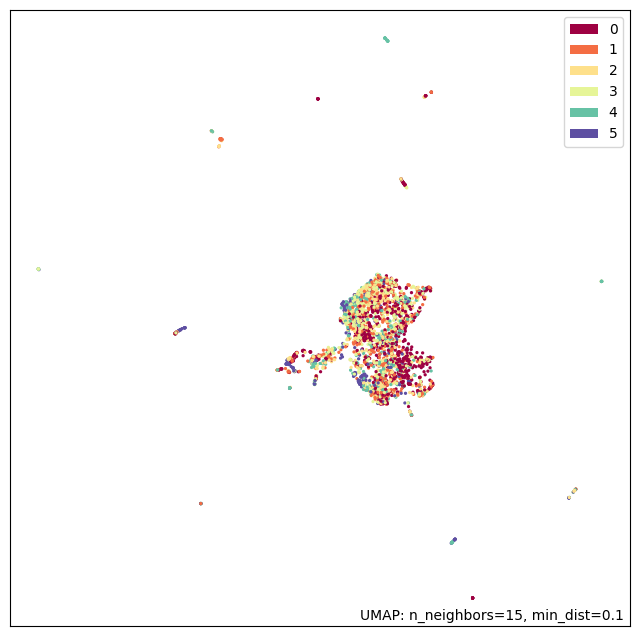

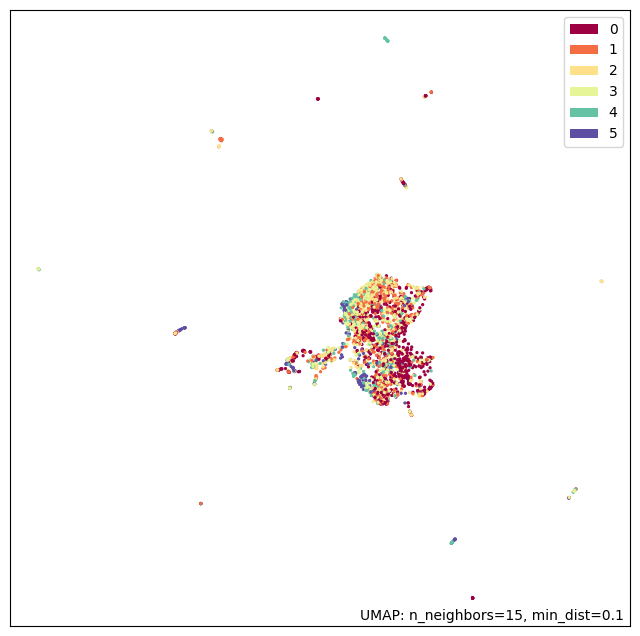

In [10]:
import umap 
import umap.plot

mapper = umap.UMAP().fit(X_val)
umap.plot.points(mapper, labels=y_val)
umap.plot.points(mapper, labels=xgb_clf.predict(X_val))

In [8]:
X_test_input = X_test.to_numpy().astype(float)
X_test_input = scaler.transform(X_test_input)
test_predictions = xgb_clf.predict(X_test_input)

submission = {
    "id" : list(range(len(test_predictions))), 
    "price" : list(test_predictions.astype(float).astype(int).astype(float))
}

submission = pd.DataFrame.from_dict(submission)

submission.to_csv(os.path.join("submissions/", "bahng_xgb_final.csv"), index=False)